![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Modelo Epidemiológico Clássico: SEIR

Neste documento investigamos a dinâmica epidemiológica da COVID19 empregando um modelo cĺássico conhecido como SEIR e algumas variações imediatas. Uma vez definido o modelo, empregamos dados históricos para estimar seus parâmetros para o caso brasileiro. Essas estimativas são usadas então para gerar dois conjuntos de dados simulados: sem e com medidas de miticação. Esses dois resultados são salvos em arquivos CSV para uso posterior em outras análises.

Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. É possível, por exemplo, experimentar com medidas de mitigação diferentes.



**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/salem/anaconda3/lib/python3.7/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, Set, Iterable


/home/salem/anaconda3/lib/python3.7/site-packages/matplotlib/backend_bases.py:57: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  from PIL import PILLOW_VERSION
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget.py:280: DeprecationWarning: Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.
  warnings.warn("Widget registration using a string name has been deprecated. Widget registration now uses a plain `@register` decorator.", DeprecationWarning)
/home/salem/anaconda3/lib/python3.7/site-packages/ipywidgets/widgets/widget_upload.py:45: DeprecationWarning: Traits should be given as instances, not types (for example, `Int()`, not `Int`). Passing types is deprecated in traitlets 4.1.
  metadata = List(Dict, help='List of file metadata').tag(sync=True)


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

Data de início da epidemia.

In [4]:
epidemic_start_date = pd.Timestamp(2020, 3, 12)

Quantida de dias.

In [5]:
epidemic_duration_in_days = 365

Tamanho da população.

In [6]:
population_size = 200 * 1e6 #18000000

Infectados inicialmente.

In [7]:
initially_infected = 52

Onde está a pasta base que contém os dados?

In [8]:
data_folder = '../data/'

Qual coluna dos dados históricos reais devemos usar para ajustar os parâmetros dos modelos?

In [9]:
data_column_to_fit =  'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_2' #'total_cases_ESTIMATED_FROM_SRAG'  #'total_cases_ESTIMATED'

Quando empregarmos dados reais para calibrar os parâmetros do modelo, qual país devemos usar?

In [10]:
target_location = 'Brazil'
#target_location = 'São Paulo-SP-Brazil'

Devemos usar os dados disponíveis para modificar algum dos parâmetros acima? Em caso positivo, dados demográficos e epidêmicos serão substituídos.

In [11]:
infer_parameters_from_data = True

Onde queremos armazenar resultados do modelo para posterior.

In [12]:
results_folder = '../results/'

Algum suffixo adicional para marcar o nome dos resultados salvos?

In [13]:
results_suffix = ''

Desejamos executar uma análise de sensibilidade também?

In [14]:
run_sensitivity_analysis = True

### Parâmetros Injetados Externamente

Este *notebook* pode também ser executado com a biblioteca [papermill](https://papermill.readthedocs.io/en/latest/index.html), de modo a customizar parâmetros sem a necessidade de editá-los diretamente aqui. Tais parâmetros customizados serão colocados na célula abaixo quando existirem, e assim tomarão o lugar dos valores dados acima.

In [15]:
# custom papermill parameters

In [16]:
# Parameters
target_location = "SE-Brazil"
infer_parameters_from_data = True
results_suffix = ".se-brazil"
run_sensitivity_analysis = False


## Funções Auxiliares

E uma função para auxiliar no desenho de gráficos. Opcionalmente, se um nome de arquivo for especificado, a função irá salvar a imagem resultante.

In [17]:
def plot_simulation_output(df_simulated_data, zoom_on=None, zoom_length=60, file_path_base=results_folder, file_name=None):
    
    def aux_file_path(x):
        return file_path_base + 'seir_' + file_name + f'_{target_location.lower()}_{x}' + results_suffix + '.png'
        
    ax = sns.lineplot(data=df_simulated_data[['S', 'E', 'I', 'R', 'E+I', 'E+I+R']])
    ax.set_title('Visão Geral da Epidemia')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('overview'), format='png')
    plt.figure()
    
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I', 'E+I+R']])
    ax.set_title('Apenas Expostos e Infecciosos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI'), format='png')
    plt.figure()
    
    peak_date = df_simulated_data["I"].idxmax().date()
    
    if zoom_on is None:    
        zoom_on = peak_date - pd.DateOffset(days=20)
        
    zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
    ax = sns.lineplot(data=df_simulated_data[['E', 'I', 'E+I']][zoom_on:zoom_end], markers=True)
    if file_name is not None:
        ax.figure.savefig(aux_file_path('EI-zoom'), format='png')
    ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
    plt.figure()
    
    df_I_delta = df_simulated_data[['I_delta']]
    df_I_delta = df_I_delta[df_I_delta > 0]
    ax = sns.lineplot(data=df_I_delta)
    ax.set_title('Infecciosos novos')
    if file_name is not None:
        ax.figure.savefig(aux_file_path('I_delta'), format='png')
    plt.figure()
    

In [18]:
def plot_curve_fitting(df_simulation_data, df_data_target, target_location, best, comparison_date=None, file_name=None):
    peak_date = df_data_target["total_cases"].idxmax().date()
    if comparison_date is None:
        comparison_date = peak_date - pd.DateOffset(days=1)
        
    df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
    
    ax = sns.lineplot(data=df_simulation_vs_real[['E+I','E+I+R', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_2', 
                                                  'total_cases_ESTIMATED_FROM_SRAG']]\
                                           [comparison_date - pd.DateOffset(days=40):comparison_date], 
                 markers=True)

    ax.set_title(f'Simulação (E+I+R) frente aos dados históriocos. Linha vertical=estimativa de intervenção (se houver).')
    
    if 'duration_1' in best:
        intervention_date_1 = epidemic_start_date + pd.DateOffset(days=int(best['duration_1']))
        plt.axvline(intervention_date_1, color='red')

    if ('duration_1' in best) and ('duration_2' in best):
        intervention_date_2 = epidemic_start_date +  pd.DateOffset(days=int(best['duration_1'])) + pd.DateOffset(days=int(best['duration_2']))
        plt.axvline(intervention_date_2, color='red')

    if file_name is not None:
        ax.figure.savefig(results_folder + file_name + f'_{target_location.lower()}' + results_suffix + '.png', 
                          format='png')

## Leitura e Preparação de Dados para Calibragem de Modelos

Mais adiante no *notebook*, empregaremos dados históricos observados para calibrar os parâmetros da simulação.  Vamos empregar dados do [Our World in Data](https://ourworldindata.org/coronavirus-source-data ). Convém assim tornar esses dados disponíveis. Isso inclui não apenas dados sobre a epidemia em si, mas também algumas informações demográficas adicionais. 

In [19]:
df_epidemy_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_locations_data = pd.read_csv(f'{data_folder}ourworldindata.org/coronavirus-source-data/locations.csv')

# enrich epidemy data with additional demographic information
df_epidemy_data = df_epidemy_data.merge(df_locations_data, on='location')

df_epidemy_data = df_epidemy_data.drop(['countriesAndTerritories', 'continent', 'population_year'], axis=1)

df_epidemy_data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
0,2019-12-31,Afghanistan,0,0,0,0,38928341.0
1,2020-01-01,Afghanistan,0,0,0,0,38928341.0


Vamos agora incorporar dados de municípios e estados brasileiros a partir da base disponibilizada pelo [Brasil.io](https://brasil.io/dataset/covid19/caso_full/). Para tanto, faremos algumas transformações para deixar o *layout* de ambas iguais e assim o *dataframe* poder ser usado de modo uniforme em seguida. Note que, para cidades e estados brasileiros, a localização terá a seguinte forma:
  - `CIDADE-ESTADO-Brazil`, para cidades.
  - `ESTADO-Brazil`, para estados.

In [20]:
df_brazil_city_data = pd.read_csv(f'{data_folder}brasil.io/dataset/covid19/caso_full.csv', parse_dates=['date'])
#print(df_brazil_city_data.tail())

def aux_build_location(row):
    if not pd.isnull(row['city']):
        prefix = f"{row['city']}-"
    else:
        prefix = ""
    
    return prefix + f"{row['state']}-Brazil"

df_brazil_city_data['location'] = df_brazil_city_data.apply(aux_build_location, axis=1)

df_brazil_city_data = df_brazil_city_data.rename(columns={"last_available_confirmed": "total_cases", "new_confirmed": "new_cases", "last_available_deaths": "total_deaths", "estimated_population_2019": "population"})
df_brazil_city_data = df_brazil_city_data[['date', 'location', 'new_cases', 'new_deaths', 'total_cases', 'total_deaths', 'population']]
df_brazil_city_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
51552,2020-02-27,SP-Brazil,0,0,1,0,45919049.0
51553,2020-02-26,São Paulo-SP-Brazil,0,0,1,0,12252023.0
51554,2020-02-26,SP-Brazil,0,0,1,0,45919049.0
51555,2020-02-25,São Paulo-SP-Brazil,1,0,1,0,12252023.0
51556,2020-02-25,SP-Brazil,1,0,1,0,45919049.0


In [21]:
df_epidemy_data = df_epidemy_data.append(df_brazil_city_data).sort_values(by=['date'])
df_epidemy_data.tail()

,date,location,new_cases,new_deaths,total_cases,total_deaths,population
941,2020-05-04,Lucas do Rio Verde-MT-Brazil,0,0,7,1,65534.0
942,2020-05-04,Mirassol d'Oeste-MT-Brazil,0,0,8,1,27739.0
943,2020-05-04,Nova Monte Verde-MT-Brazil,0,0,1,0,9178.0
925,2020-05-04,Alta Floresta-MT-Brazil,0,0,2,0,51782.0
292,2020-05-04,Acaraú-CE-Brazil,0,0,31,1,62641.0


Selecionemos apenas dados sobre o país de interesse.

In [22]:
df_data_target = df_epidemy_data[df_epidemy_data['location']==target_location].copy().set_index(['date']).drop('location', axis=1)

In [23]:
df_srag_adjustment_multipliers = pd.read_csv(f'{results_folder}srag_adjustment_multipliers.brazil.csv', parse_dates=['date'], index_col=0)
df_srag_adjustment_multipliers.tail()

,SRAG_adjustment_multiplier
date,
2020-04-07,3.595084
2020-04-08,3.595084
2020-04-09,3.595084
2020-04-10,3.595084
2020-04-11,3.595084


Antes de prosseguir, vamos enriquer esses dados com algumas suposições.

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,173,3,453,14,2298696.0,NaN,6795,NaN
2020-05-01,64,0,517,14,2298696.0,NaN,7755,NaN
2020-05-02,84,0,601,14,2298696.0,NaN,9015,NaN
2020-05-03,129,0,730,14,2298696.0,NaN,10950,NaN
2020-05-04,0,0,730,14,2298696.0,NaN,10950,NaN


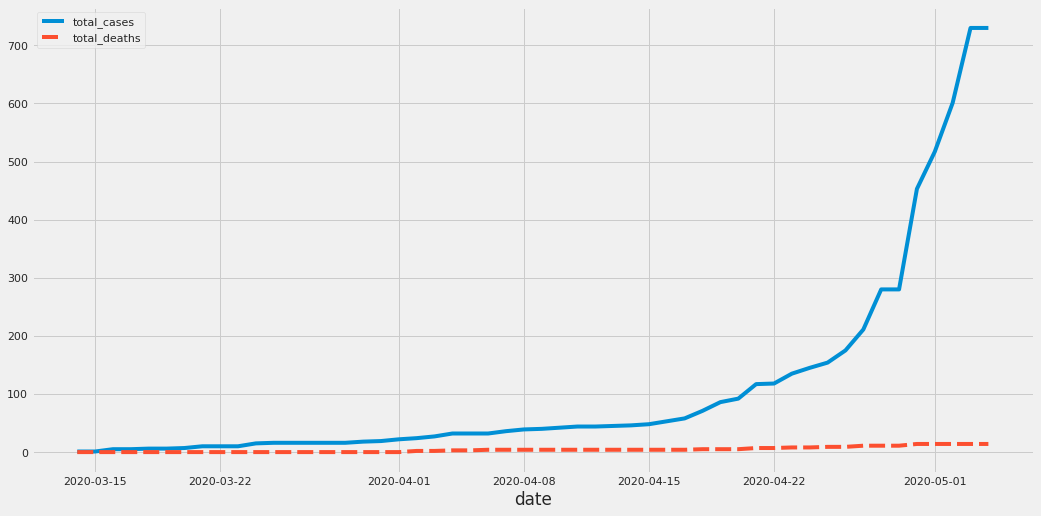

In [24]:
df_data_target['total_cases_ESTIMATED'] = (df_data_target['total_deaths'] / 0.05).shift(-7)
df_data_target['total_cases_ESTIMATED_2'] = 15 * df_data_target['total_cases']

# we have data for SRAG in Brazil only 
if target_location == 'Brazil':
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = \
        (df_data_target['new_cases'] * df_srag_adjustment_multipliers['SRAG_adjustment_multiplier'].reindex_like(df_data_target, method='ffill'))\
            .cumsum()
else:
    df_data_target['total_cases_ESTIMATED_FROM_SRAG'] = df_data_target['new_cases'] * np.nan

sns.lineplot(data=df_data_target[['total_cases', 'total_deaths']])
df_data_target.tail()

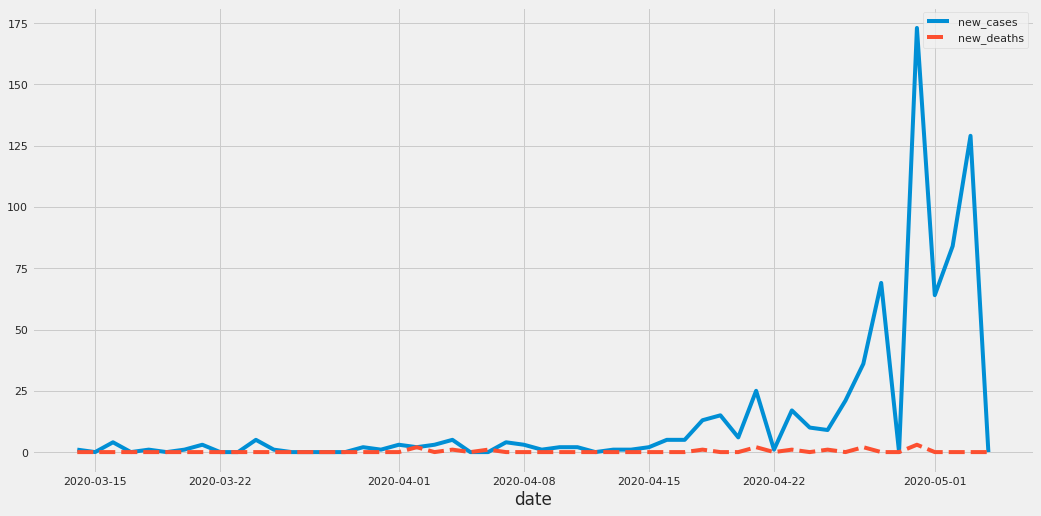

In [25]:
sns.lineplot(data=df_data_target[['new_cases', 'new_deaths']])

### Substituição de Parâmetros

Se requisitado, vamos substituir alguns dos parâmetros por valores presentes nos dados.

In [26]:
df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]

Timestamp('2020-04-16 00:00:00')

In [27]:
if infer_parameters_from_data:
    epidemic_start_date = df_data_target[df_data_target['total_cases'] >= 50]['total_cases'].index[0]
    
    first_date_row = df_data_target.loc[epidemic_start_date]
    population_size = first_date_row['population']
    initially_infected = first_date_row[data_column_to_fit] #['total_cases']
    
    print(f'NEW VALUES: epidemic_start_date={epidemic_start_date}, population_size={population_size}, initially_infected={initially_infected}')
    

NEW VALUES: epidemic_start_date=2020-04-16 00:00:00, population_size=2298696.0, initially_infected=795.0


Filtremos os dados a partir da data de interesse.

In [28]:
df_data_target = df_data_target[epidemic_start_date:]

## Modelo SEIR

O [modelo SEIR](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) é um dos modos clássicos de se representar a dinâmica de epidemias. Trata-se de um chamado "modelo de compartimento", no qual temos alguns compartimentos principais:

  - S(t): número de indivíduos suscetíveis em função do tempo.
  - E(t): número de expostos, mas ainda não transmissores, em função do tempo.
  - I(t): número de indivíduos infecciosos em função do tempo.
  - R(t): número de indivíduos que se recuperam em função do tempo.
  
São também necessários dois outros parâmetros, que definem taxas de transição entre compartimentos:
  
  - beta: valor entre 0.0 e 1.0 que define a taxa de S para E (i.e., taxa de exposição)
  - alpha: valor entre 0.0 e 1.0 que define a taxa de E para I (i.e., taxa de contaminação)
  - gamma: valor entre 0.0 e 1.0 que define a taxa de I para R (i.e., taxa de recuperação)

Tradicionalmente, esse modelo é tratado via equações diferenciais. Aqui, adotaremos uma implementação via simulações estocásticas, o que nos permitirá posteriormente realizar modificações variadas que talvez não sejam tratáveis analiticamente.

### Funções Auxiliares

Antes de prosseguir, vamos definir algumas funções auxliares que garantirão que os valores acrescidos ou subtraídos nos diversos compartimentos não ultrapassem valores limites.

In [29]:
def aux_enforce_max_addition(Q, delta):
    if Q - delta <= 0:
        return Q
    
    else:
        return delta
    
def aux_enforce_max_removal(Q, delta):
    if Q + delta <= 0:
        return -Q
    else:
        return delta

Ao longo de uma epidemia, é razoável supor que autoridades sanitárias e, de fato, a polulação como um todo, adotarão medidas que possam reduzir o contágio e melhorar as chances de recuperação. Isso pode ser modelado com parâmetros dinâmicos, supondo-se intervenções em momentos precisos do tempo. Assim, os parâmetros do modelo aqui proposto podem ser tanto escalares quanto dicionários que mapeiam instantes a valores naqueles instantes. Para que a simulação possa usar transparentemente qualquer caso, definimos a seguir uma função que extrai o valor do parâmetro conforme o caso.

In [30]:
def param_at(param_var, t):
    if isinstance(param_var, dict):
        return param_var[t]
    
    else:
        return param_var

Convém também ter uma função para montar as sequências de parâmetros (veremos um exemplo mais adiante para entender seu uso).

In [31]:
def dynamic_parameter(regimens, min_length):
    i = 0
    params = {}
    last_value = None
    min_length = int(min_length)
    for value, length in regimens:
        length = int(length)
        param = {t: value for t in range(i, i + length)}
        params.update(param)
        i += length
        last_value = value
    
    # if we do not have enough data, fill in the remaining entries with the last specified value
    if i < min_length:
        param = {t: last_value for t in range(i, i + min_length)}
        params.update(param)

    return params

### Funções dos Compartimentos

Podemos agora definir a dinâmica dos diversos compartimentos contemplados no modelo.

In [32]:
def s(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_removal(S, 
                                    -((param_at(beta, t) * I * S) / population_size))
    
    return delta

In [33]:
def e(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    delta = aux_enforce_max_removal(E,  
                                    param_at(delta_s, t) - param_at(alpha, t)*E)    
    
        
    return delta

In [34]:
def i(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
        
    delta = aux_enforce_max_removal(I, 
                                    param_at(delta_e, t) - param_at(gamma, t)*I)
        
    return delta

In [35]:
def r(t, S, E, I, R, alpha, beta, gamma):
    delta = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta

Também convém poder calcular a variação dos compartimentos E e I para posterior análise.

In [36]:
# how many new patients will be added to E
def e_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_s = aux_enforce_max_addition(S, 
                                       ((param_at(beta, t) * I * S) / population_size))
    
    return delta_s

In [37]:
# how many new patients will be added to I
def i_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_e = aux_enforce_max_addition(E, 
                                       param_at(alpha, t)*E)
    
    return delta_e

In [38]:
# how many new patients will be added to R
def r_delta(t, S, E, I, R, alpha, beta, gamma):
    delta_r = aux_enforce_max_addition(I,
                                     param_at(gamma, t)*I)
    
    return delta_r

### Simulação

A simulação então pode ser definida do seguinte modo.

In [39]:
def simulate(S, E, I, R, alpha, beta, gamma, epidemic_start_date, epidemic_duration_in_days, 
             s_func, e_func, i_func, r_func, e_delta_func, i_delta_func, r_delta_func):
    
    generated_data = [] # initial data
    
    # changes start at 0
    E_delta = 0
    I_delta = 0 
    R_delta = 0
    
    for t in range(0, epidemic_duration_in_days):
        generated_data.append((S, E, E_delta, I, I_delta, R, R_delta))
        
        # main model components
        S_next = S + s_func(t, S, E, I, R, alpha, beta, gamma)
        E_next = E + e_func(t, S, E, I, R, alpha, beta, gamma)
        I_next = I + i_func(t, S, E, I, R, alpha, beta, gamma)
        R_next = R + r_func(t, S, E, I, R, alpha, beta, gamma)
        
        # added information for later analyses
        I_delta = i_delta_func(t, S, E, I, R, alpha, beta, gamma)
        E_delta = e_delta_func(t, S, E, I, R, alpha, beta, gamma)
        R_delta = r_delta_func(t, S, E, I, R, alpha, beta, gamma)

        # lockstep updates
        S = S_next
        E = E_next
        I = I_next
        R = R_next

        assert math.isclose(S + E + I + R, population_size, rel_tol=1e-9, abs_tol=0.0), "Population size must not change."
    
    df = pd.DataFrame(generated_data,
                      columns=['S', 'E', 'E_delta', 'I', 'I_delta', 'R', 'R_delta'],
                      index=pd.date_range(start=epidemic_start_date, periods=epidemic_duration_in_days, freq='D'))
    
    df['E+I'] = df['E'] + df['I']
    df['E+I+R'] = df['E'] + df['I'] + df['R']
    
    return df

Podemos agora simular situações de interesse definindo os parâmetros do modelo.

In [40]:
alpha = 0.9   # E to I rate
beta = 0.8   # S to E rate
gamma = 0.3  # I to R rate

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-16,2.297901e+06,795.000000,0.000000,0.000000,0.000000,0.00000,0.00000,795.000000,795.000000
2020-04-17,2.297901e+06,79.500000,0.000000,715.500000,715.500000,0.00000,0.00000,795.000000,795.000000
2020-04-18,2.297329e+06,580.152036,572.202036,572.400000,71.550000,214.65000,214.65000,1152.552036,1367.202036
2020-04-19,2.296871e+06,515.662845,457.647642,922.816833,522.136833,386.37000,171.72000,1438.479678,1824.849678
2020-04-20,2.296133e+06,789.233679,737.667394,1110.068344,464.096561,663.21505,276.84505,1899.302022,2562.517072


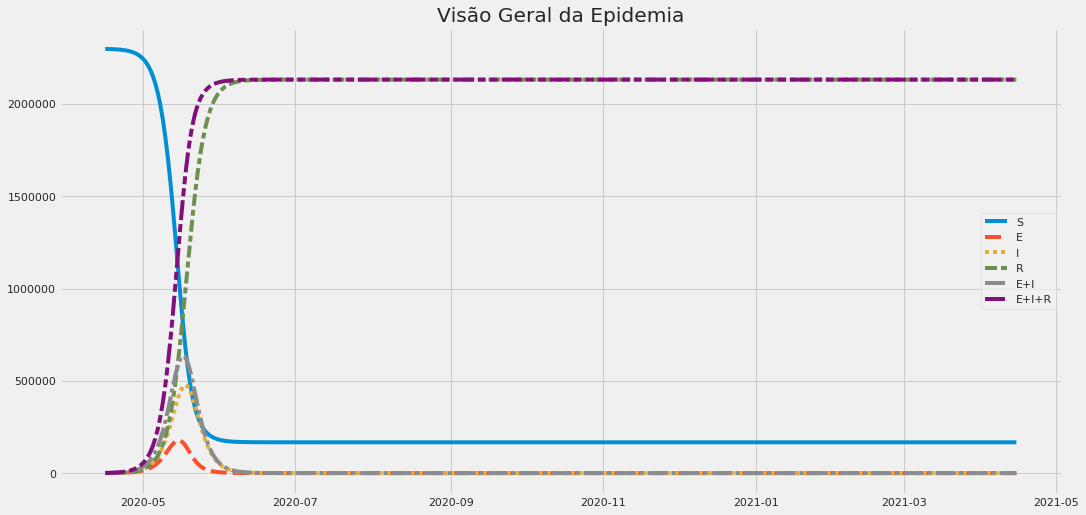

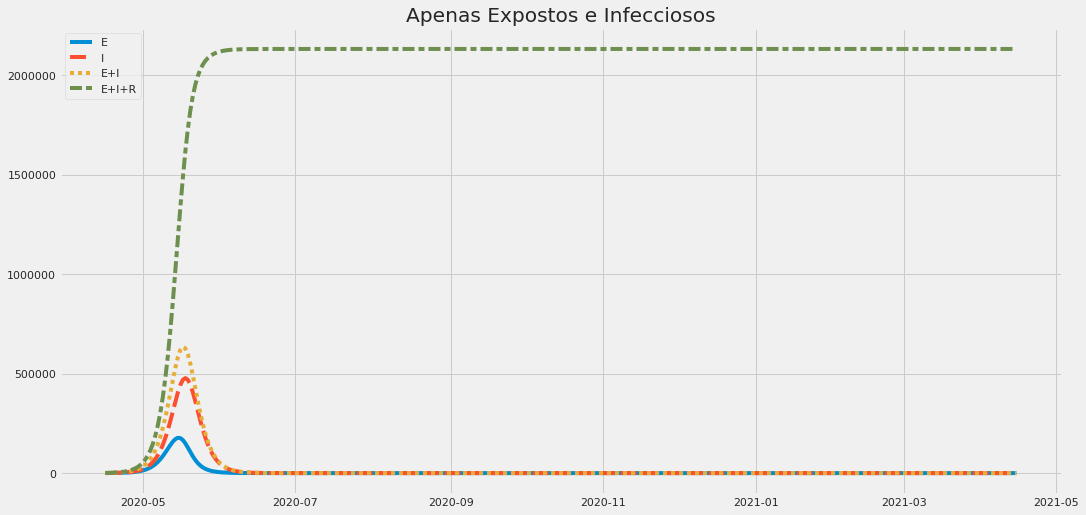

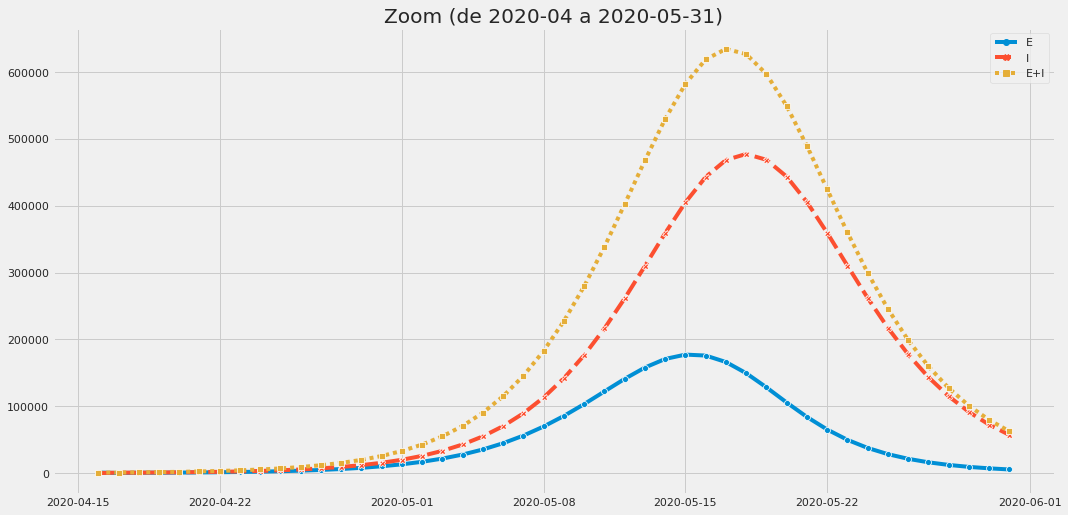

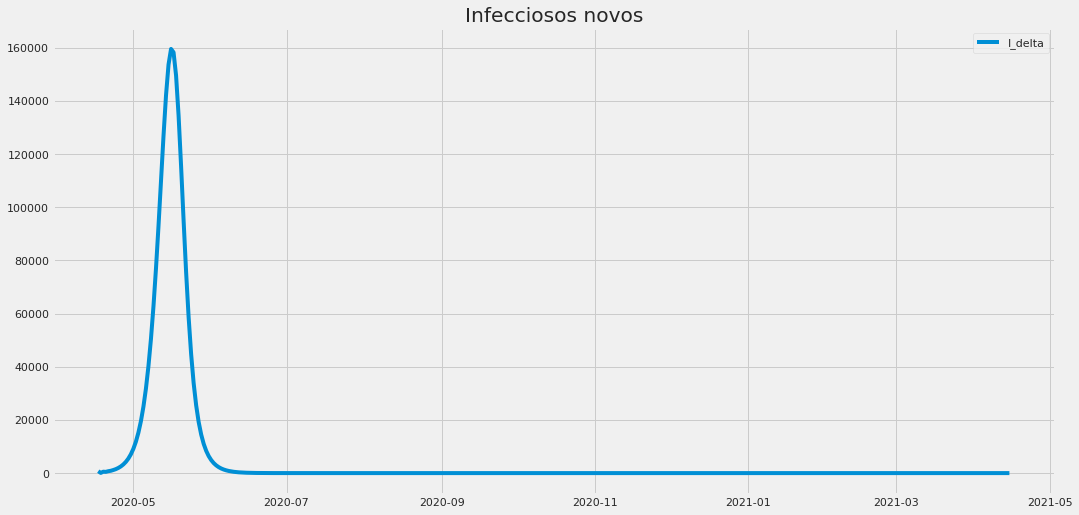

<Figure size 1152x576 with 0 Axes>

In [41]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data, zoom_on='2020-04')
df_simulation_data.head()

Como isso se compara visualmente com os dados reais observados?

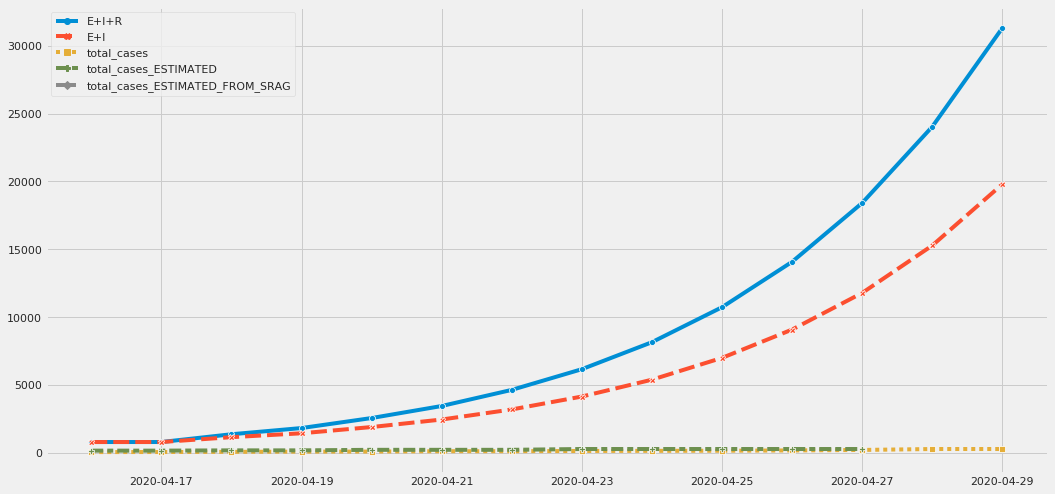

In [42]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=7)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED', 'total_cases_ESTIMATED_FROM_SRAG']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

Vejamos um exemplo agora de parâmetro dinâmico. Vamos definir o parâmetro *beta* como 0.3 nos primeiros 30 dias, 0.25 nos 60 dias seguintes e 0.2 daí em diante.

In [43]:
alpha = 1.0

beta = dynamic_parameter([(0.9, 10), 
                          (0.8, epidemic_duration_in_days)], min_length=epidemic_duration_in_days)

gamma = 0.4

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-16,2.297901e+06,795.000000,0.000000,0.000000,0.000000,0.000000,0.000000,795.000000,795.000000
2020-04-17,2.297901e+06,0.000000,0.000000,795.000000,795.000000,0.000000,0.000000,795.000000,795.000000
2020-04-18,2.297186e+06,715.252546,715.252546,477.000000,0.000000,318.000000,318.000000,1192.252546,1510.252546
2020-04-19,2.296757e+06,429.017948,429.017948,1001.452546,715.252546,508.800000,190.800000,1430.470494,1939.270494
2020-04-20,2.295856e+06,900.546913,900.546913,1029.889476,429.017948,909.381018,400.581018,1930.436388,2839.817406


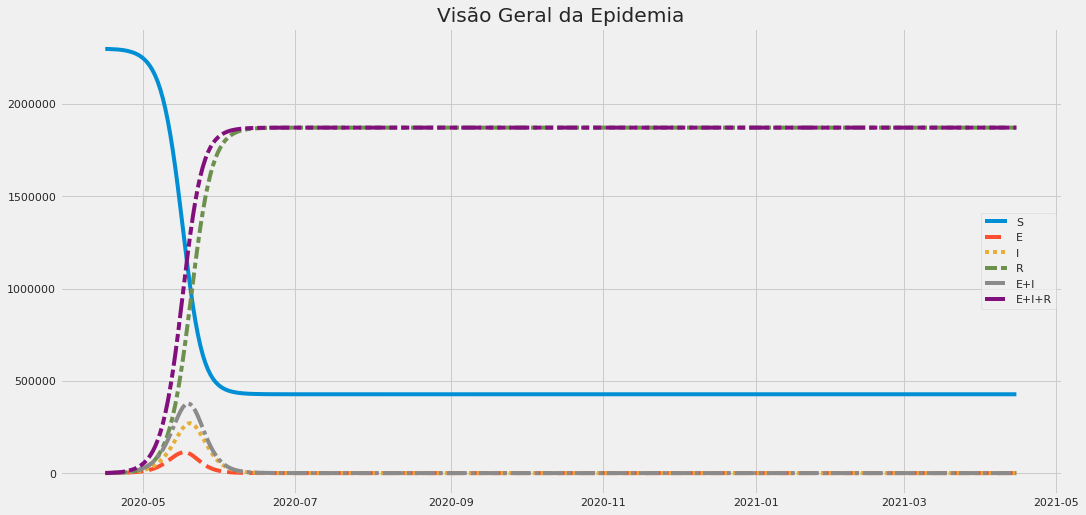

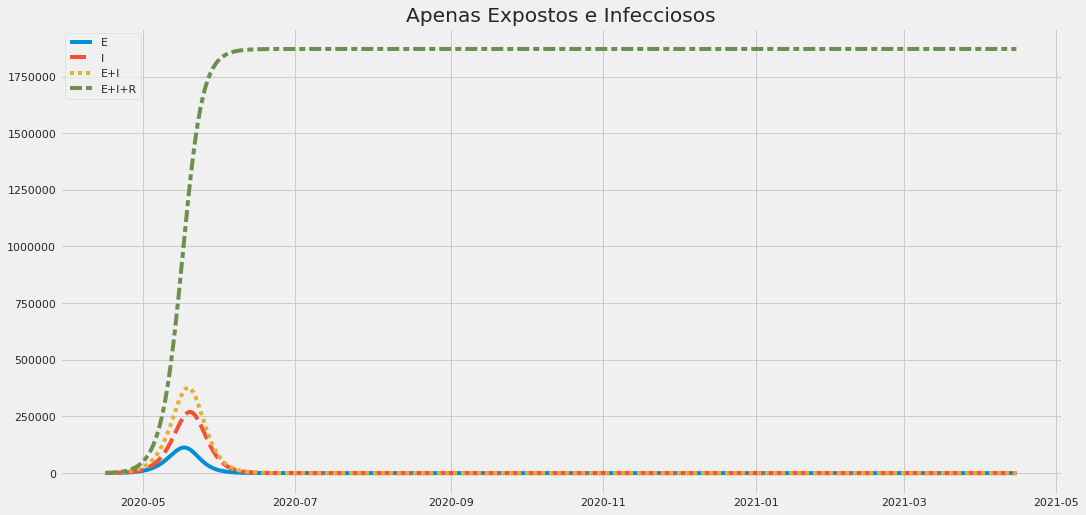

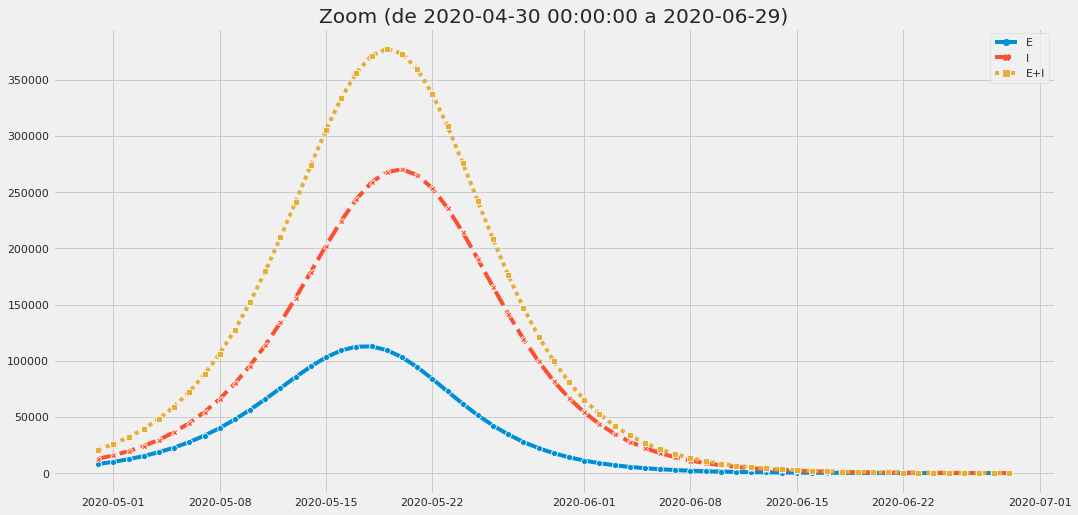

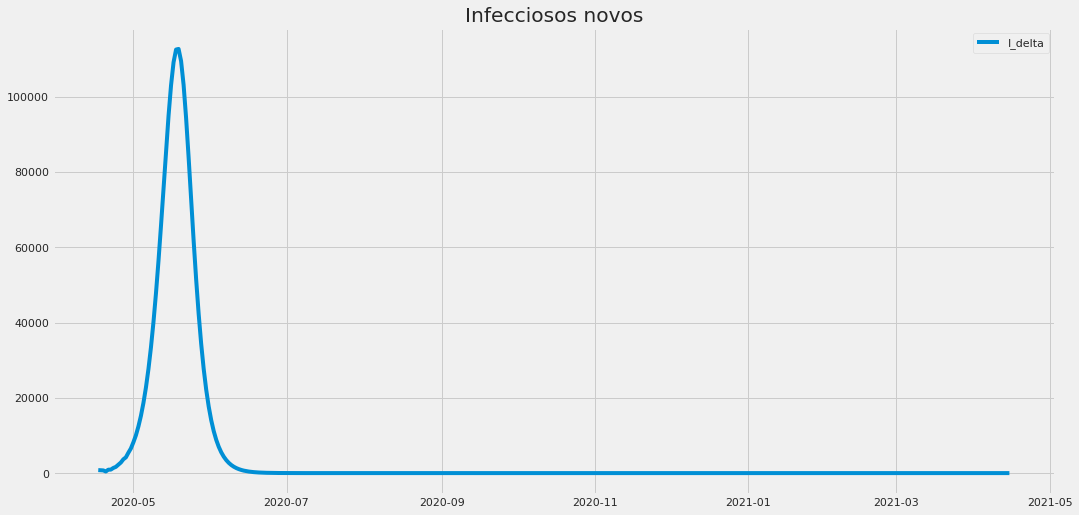

<Figure size 1152x576 with 0 Axes>

In [44]:
df_simulation_data = simulate(S=population_size - initially_infected, 
                              E =initially_infected, 
                              I=0, 
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date,
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e, 
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data.head()

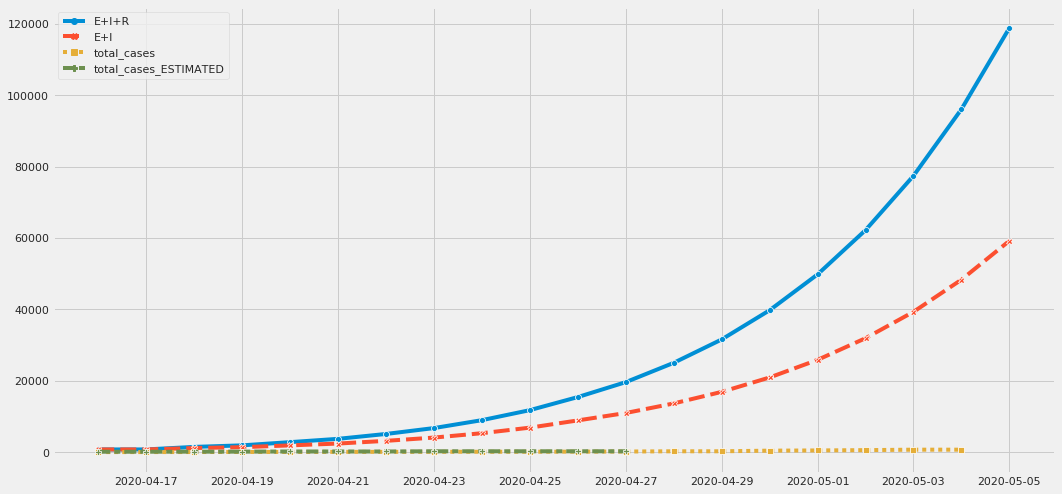

In [45]:
comparison_date = pd.Timestamp.today() - pd.DateOffset(days=1)
df_simulation_vs_real = pd.concat([df_simulation_data, df_data_target], axis=1)
sns.lineplot(data=df_simulation_vs_real[['E+I+R', 'E+I', 'total_cases', 'total_cases_ESTIMATED']]\
                                       [comparison_date - pd.DateOffset(days=20):comparison_date], 
             markers=True)

## Calibragem de Parâmetros

Podemos agora confrontar os modelos acima com dados reais observados e, assim, encontrar os parâmetros que melhor aproximam a realidade.

Faremos a busca de parâmetros empregando a biblioteca [hyperopt](https://github.com/hyperopt/hyperopt). Para tanto, precisamos definir uma função objetivo a ser otimizada. Aqui, essa função executa uma simulação com os parâmetros (*alpha*, *beta* e *gamma*) sugeridos, obtém a curva de infecções resultante e calcula o erro absoluto médio com relação às datas para as quais temos as observações reais.

In [46]:
def objective_for_simulation(args):
    ##################################################################
    # What kind of parameters we are optimizing? Constant or dynamic?
    ##################################################################
    if 'constant' in args:
        alpha, beta, gamma, t_min, t_max = args['constant']
    elif 'dynamic' in args:
        params_sets, t_min, t_max = args['dynamic'] # TODO
        alpha = []
        beta = []
        gamma = []
        prev_alpha = None
        prev_beta = None
        prev_gamma = None
        prev_duration = None
        for params in params_sets:
            cur_alpha = params.get('alpha', prev_alpha)
            cur_beta = params.get('beta', prev_beta)
            cur_gamma = params.get('gamma', prev_gamma)
            cur_duration = int(params.get('duration', prev_duration))
            
            alpha.append((cur_alpha, cur_duration))
            beta.append((cur_beta, cur_duration))
            gamma.append((cur_gamma, cur_duration))
            
            prev_alpha = cur_alpha
            prev_beta = cur_beta
            prev_gamma = cur_gamma
            prev_duration = cur_duration
        
        alpha = dynamic_parameter(alpha, min_length=epidemic_duration_in_days)
        beta = dynamic_parameter(beta, min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter(gamma, min_length=epidemic_duration_in_days)
        
    ###########
    # Simulate
    ###########
    df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha,beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,  
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)
    
    # run simulation
    df_simulation_data_filtered = df_simulation_data[df_simulation_data.index.isin(df_data_target.index.values)]
    
    ###################
    # Calculate error
    ###################
    df_diff_cases = df_data_target[data_column_to_fit] - \
                               (df_simulation_data_filtered['I'] + df_simulation_data_filtered['E'] + df_simulation_data_filtered['R'])
    
    # we can limit the temporal reach of the estimation if desired
    if t_min is not None and t_max is not None:
        df_diff_cases = df_diff_cases.iloc[t_min:t_max] 
    
    values = df_diff_cases.dropna().values

    mae = np.mean(abs(values)) #mean absolute error

    return mae

### Com Parâmetros Constantes

Suponhamos que os parâmetros do modelo sejam constantes, ou seja, que não haja mudanças de comportamento ou políticas ao longo da epidemia.

Definimos então o espaço de busca dos parâmetros e efetivamente executamos a busca.

In [47]:
#space = {'constant': (hyperopt.hp.uniform('alpha', 0.0, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, None)}
space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, 15)}

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=1000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/1000 [00:00<?, ?trial/s, best loss=?]

  1%|          | 8/1000 [00:00<00:14, 70.10trial/s, best loss: 578.9178170211943]

  2%|▏         | 20/1000 [00:00<00:12, 79.45trial/s, best loss: 551.0742786118484]

  3%|▎         | 29/1000 [00:00<00:11, 81.75trial/s, best loss: 551.0742786118484]

  4%|▍         | 38/1000 [00:00<00:11, 83.94trial/s, best loss: 551.0742786118484]

  5%|▍         | 47/1000 [00:00<00:11, 84.12trial/s, best loss: 522.3900649595736]

  6%|▌         | 56/1000 [00:00<00:11, 85.59trial/s, best loss: 522.3900649595736]

  6%|▋         | 65/1000 [00:00<00:10, 86.19trial/s, best loss: 522.3900649595736]

  7%|▋         | 74/1000 [00:00<00:10, 87.06trial/s, best loss: 457.2065671241741]

  8%|▊         | 83/1000 [00:00<00:10, 87.69trial/s, best loss: 373.6308107193954]

  9%|▉         | 92/1000 [00:01<00:10, 88.20trial/s, best loss: 289.9583815947534]

 10%|█         | 101/1000 [00:01<00:10, 84.98trial/s, best loss: 289.9583815947534]

 11%|█         | 110/1000 [00:01<00:10, 81.78trial/s, best loss: 289.9583815947534]

 12%|█▏        | 119/1000 [00:01<00:10, 83.15trial/s, best loss: 289.9583815947534]

 13%|█▎        | 128/1000 [00:01<00:10, 83.21trial/s, best loss: 289.9583815947534]

 14%|█▎        | 137/1000 [00:01<00:10, 82.48trial/s, best loss: 288.78267911458164]

 15%|█▍        | 146/1000 [00:01<00:10, 82.36trial/s, best loss: 284.3515341507339] 

 16%|█▌        | 155/1000 [00:01<00:10, 82.02trial/s, best loss: 271.8417328541654]

 16%|█▋        | 164/1000 [00:01<00:10, 81.96trial/s, best loss: 271.8417328541654]

 17%|█▋        | 173/1000 [00:02<00:10, 82.32trial/s, best loss: 271.8417328541654]

 18%|█▊        | 182/1000 [00:02<00:10, 78.66trial/s, best loss: 271.8417328541654]

 19%|█▉        | 190/1000 [00:02<00:11, 72.88trial/s, best loss: 271.8417328541654]

 20%|█▉        | 198/1000 [00:02<00:10, 74.25trial/s, best loss: 271.8417328541654]

 21%|██        | 207/1000 [00:02<00:10, 76.22trial/s, best loss: 271.8417328541654]

 22%|██▏       | 215/1000 [00:02<00:10, 77.10trial/s, best loss: 271.8417328541654]

 22%|██▏       | 223/1000 [00:02<00:10, 77.65trial/s, best loss: 271.8417328541654]

 23%|██▎       | 231/1000 [00:02<00:09, 77.84trial/s, best loss: 271.8417328541654]

 24%|██▍       | 239/1000 [00:02<00:10, 74.82trial/s, best loss: 271.8417328541654]

 25%|██▍       | 247/1000 [00:03<00:09, 76.19trial/s, best loss: 271.8417328541654]

 26%|██▌       | 255/1000 [00:03<00:10, 73.15trial/s, best loss: 271.8417328541654]

 26%|██▋       | 263/1000 [00:03<00:10, 73.51trial/s, best loss: 271.8417328541654]

 27%|██▋       | 271/1000 [00:03<00:09, 73.59trial/s, best loss: 271.8417328541654]

 28%|██▊       | 279/1000 [00:03<00:09, 73.93trial/s, best loss: 271.8417328541654]

 29%|██▊       | 287/1000 [00:03<00:09, 73.72trial/s, best loss: 271.8417328541654]

 30%|██▉       | 295/1000 [00:03<00:09, 73.75trial/s, best loss: 271.8417328541654]

 30%|███       | 303/1000 [00:03<00:09, 74.12trial/s, best loss: 271.8417328541654]

 31%|███       | 311/1000 [00:03<00:09, 74.10trial/s, best loss: 271.8417328541654]

 32%|███▏      | 319/1000 [00:04<00:09, 74.38trial/s, best loss: 271.8417328541654]

 33%|███▎      | 327/1000 [00:04<00:09, 70.74trial/s, best loss: 271.8417328541654]

 34%|███▎      | 335/1000 [00:04<00:09, 70.99trial/s, best loss: 271.8417328541654]

 34%|███▍      | 343/1000 [00:04<00:09, 70.88trial/s, best loss: 271.8417328541654]

 35%|███▌      | 351/1000 [00:04<00:09, 70.14trial/s, best loss: 271.8417328541654]

 36%|███▌      | 359/1000 [00:04<00:09, 69.59trial/s, best loss: 271.8417328541654]

 37%|███▋      | 366/1000 [00:04<00:09, 68.48trial/s, best loss: 271.8417328541654]

 37%|███▋      | 373/1000 [00:04<00:09, 67.84trial/s, best loss: 271.8417328541654]

 38%|███▊      | 380/1000 [00:04<00:10, 58.52trial/s, best loss: 271.8417328541654]

 39%|███▊      | 387/1000 [00:05<00:10, 60.56trial/s, best loss: 271.8417328541654]

 39%|███▉      | 394/1000 [00:05<00:10, 59.32trial/s, best loss: 271.8417328541654]

 40%|████      | 401/1000 [00:05<00:09, 60.59trial/s, best loss: 270.36681675564034]

 41%|████      | 408/1000 [00:05<00:09, 61.73trial/s, best loss: 270.36681675564034]

 42%|████▏     | 415/1000 [00:05<00:09, 62.81trial/s, best loss: 270.36681675564034]

 42%|████▏     | 422/1000 [00:05<00:09, 63.74trial/s, best loss: 270.36681675564034]

 43%|████▎     | 429/1000 [00:05<00:08, 64.13trial/s, best loss: 270.36681675564034]

 44%|████▎     | 436/1000 [00:05<00:08, 64.32trial/s, best loss: 270.36681675564034]

 44%|████▍     | 443/1000 [00:05<00:08, 64.66trial/s, best loss: 270.36681675564034]

 45%|████▌     | 450/1000 [00:06<00:08, 64.75trial/s, best loss: 270.36681675564034]

 46%|████▌     | 457/1000 [00:06<00:09, 59.71trial/s, best loss: 270.36681675564034]

 46%|████▋     | 464/1000 [00:06<00:08, 59.58trial/s, best loss: 270.36681675564034]

 47%|████▋     | 471/1000 [00:06<00:08, 60.60trial/s, best loss: 270.36681675564034]

 48%|████▊     | 478/1000 [00:06<00:08, 61.38trial/s, best loss: 270.36681675564034]

 48%|████▊     | 485/1000 [00:06<00:08, 61.70trial/s, best loss: 270.36681675564034]

 49%|████▉     | 492/1000 [00:06<00:08, 61.85trial/s, best loss: 270.36681675564034]

 50%|████▉     | 499/1000 [00:06<00:08, 61.54trial/s, best loss: 270.36681675564034]

 51%|█████     | 506/1000 [00:06<00:07, 61.77trial/s, best loss: 270.36681675564034]

 51%|█████▏    | 513/1000 [00:07<00:07, 60.99trial/s, best loss: 270.36681675564034]

 52%|█████▏    | 520/1000 [00:07<00:07, 60.56trial/s, best loss: 270.36681675564034]

 53%|█████▎    | 527/1000 [00:07<00:07, 60.32trial/s, best loss: 270.36681675564034]

 53%|█████▎    | 534/1000 [00:07<00:07, 59.98trial/s, best loss: 270.36681675564034]

 54%|█████▍    | 541/1000 [00:07<00:07, 60.04trial/s, best loss: 270.36681675564034]

 55%|█████▍    | 548/1000 [00:07<00:07, 60.11trial/s, best loss: 270.36681675564034]

 56%|█████▌    | 555/1000 [00:07<00:07, 59.37trial/s, best loss: 270.36681675564034]

 56%|█████▌    | 561/1000 [00:07<00:07, 56.51trial/s, best loss: 270.36681675564034]

 57%|█████▋    | 567/1000 [00:08<00:07, 55.58trial/s, best loss: 270.36681675564034]

 57%|█████▋    | 573/1000 [00:08<00:07, 53.85trial/s, best loss: 270.36681675564034]

 58%|█████▊    | 579/1000 [00:08<00:08, 50.66trial/s, best loss: 270.36681675564034]

 58%|█████▊    | 585/1000 [00:08<00:07, 52.91trial/s, best loss: 270.36681675564034]

 59%|█████▉    | 591/1000 [00:08<00:07, 54.13trial/s, best loss: 270.36681675564034]

 60%|█████▉    | 597/1000 [00:08<00:07, 55.12trial/s, best loss: 270.36681675564034]

 60%|██████    | 603/1000 [00:08<00:07, 55.97trial/s, best loss: 270.36681675564034]

 61%|██████    | 609/1000 [00:08<00:06, 56.89trial/s, best loss: 270.36681675564034]

 62%|██████▏   | 615/1000 [00:08<00:07, 53.12trial/s, best loss: 270.36681675564034]

 62%|██████▏   | 621/1000 [00:09<00:06, 54.28trial/s, best loss: 270.36681675564034]

 63%|██████▎   | 627/1000 [00:09<00:07, 51.15trial/s, best loss: 270.36681675564034]

 63%|██████▎   | 633/1000 [00:09<00:07, 51.26trial/s, best loss: 270.36681675564034]

 64%|██████▍   | 639/1000 [00:09<00:07, 51.17trial/s, best loss: 270.36681675564034]

 64%|██████▍   | 645/1000 [00:09<00:06, 52.42trial/s, best loss: 270.36681675564034]

 65%|██████▌   | 651/1000 [00:09<00:06, 53.65trial/s, best loss: 270.36681675564034]

 66%|██████▌   | 657/1000 [00:09<00:06, 54.43trial/s, best loss: 270.36681675564034]

 66%|██████▋   | 663/1000 [00:09<00:06, 55.02trial/s, best loss: 270.36681675564034]

 67%|██████▋   | 669/1000 [00:09<00:05, 55.38trial/s, best loss: 270.36681675564034]

 68%|██████▊   | 675/1000 [00:10<00:05, 55.64trial/s, best loss: 270.36681675564034]

 68%|██████▊   | 681/1000 [00:10<00:06, 50.88trial/s, best loss: 270.36681675564034]

 69%|██████▊   | 687/1000 [00:10<00:06, 46.21trial/s, best loss: 270.36681675564034]

 69%|██████▉   | 693/1000 [00:10<00:06, 48.59trial/s, best loss: 270.36681675564034]

 70%|██████▉   | 699/1000 [00:10<00:06, 50.00trial/s, best loss: 270.36681675564034]

 70%|███████   | 705/1000 [00:10<00:05, 51.06trial/s, best loss: 270.36681675564034]

 71%|███████   | 711/1000 [00:10<00:05, 51.67trial/s, best loss: 270.36681675564034]

 72%|███████▏  | 717/1000 [00:10<00:05, 51.97trial/s, best loss: 270.36681675564034]

 72%|███████▏  | 723/1000 [00:11<00:05, 47.49trial/s, best loss: 270.36681675564034]

 73%|███████▎  | 728/1000 [00:11<00:05, 47.57trial/s, best loss: 270.36681675564034]

 73%|███████▎  | 734/1000 [00:11<00:05, 48.72trial/s, best loss: 270.36681675564034]

 74%|███████▍  | 740/1000 [00:11<00:05, 50.28trial/s, best loss: 270.36681675564034]

 75%|███████▍  | 746/1000 [00:11<00:04, 51.23trial/s, best loss: 270.36681675564034]

 75%|███████▌  | 752/1000 [00:11<00:04, 52.03trial/s, best loss: 270.36681675564034]

 76%|███████▌  | 758/1000 [00:11<00:04, 52.57trial/s, best loss: 270.36681675564034]

 76%|███████▋  | 764/1000 [00:11<00:04, 52.87trial/s, best loss: 270.36681675564034]

 77%|███████▋  | 770/1000 [00:11<00:04, 52.83trial/s, best loss: 270.36681675564034]

 78%|███████▊  | 776/1000 [00:12<00:04, 52.01trial/s, best loss: 270.36681675564034]

 78%|███████▊  | 782/1000 [00:12<00:04, 50.89trial/s, best loss: 270.36681675564034]

 79%|███████▉  | 788/1000 [00:12<00:04, 49.77trial/s, best loss: 270.36681675564034]

 79%|███████▉  | 793/1000 [00:12<00:04, 49.33trial/s, best loss: 270.36681675564034]

 80%|███████▉  | 799/1000 [00:12<00:04, 50.12trial/s, best loss: 270.36681675564034]

 80%|████████  | 805/1000 [00:12<00:03, 49.87trial/s, best loss: 270.36681675564034]

 81%|████████  | 811/1000 [00:12<00:03, 50.05trial/s, best loss: 270.36681675564034]

 82%|████████▏ | 817/1000 [00:12<00:03, 49.99trial/s, best loss: 270.36681675564034]

 82%|████████▏ | 823/1000 [00:13<00:03, 50.03trial/s, best loss: 270.36681675564034]

 83%|████████▎ | 829/1000 [00:13<00:03, 48.59trial/s, best loss: 270.36681675564034]

 84%|████████▎ | 835/1000 [00:13<00:03, 49.31trial/s, best loss: 270.36681675564034]

 84%|████████▍ | 841/1000 [00:13<00:03, 50.12trial/s, best loss: 270.36681675564034]

 85%|████████▍ | 847/1000 [00:13<00:03, 50.54trial/s, best loss: 270.36681675564034]

 85%|████████▌ | 853/1000 [00:13<00:02, 50.58trial/s, best loss: 270.36681675564034]

 86%|████████▌ | 859/1000 [00:13<00:02, 50.68trial/s, best loss: 270.36681675564034]

 86%|████████▋ | 865/1000 [00:13<00:02, 45.33trial/s, best loss: 270.36681675564034]

 87%|████████▋ | 871/1000 [00:14<00:02, 46.85trial/s, best loss: 270.36681675564034]

 88%|████████▊ | 876/1000 [00:14<00:02, 46.13trial/s, best loss: 270.36681675564034]

 88%|████████▊ | 881/1000 [00:14<00:02, 46.43trial/s, best loss: 270.36681675564034]

 89%|████████▊ | 886/1000 [00:14<00:02, 47.01trial/s, best loss: 270.36681675564034]

 89%|████████▉ | 891/1000 [00:14<00:02, 47.78trial/s, best loss: 270.36681675564034]

 90%|████████▉ | 896/1000 [00:14<00:02, 48.18trial/s, best loss: 270.36681675564034]

 90%|█████████ | 902/1000 [00:14<00:02, 48.69trial/s, best loss: 270.36681675564034]

 91%|█████████ | 907/1000 [00:14<00:01, 48.29trial/s, best loss: 270.36681675564034]

 91%|█████████ | 912/1000 [00:14<00:01, 48.15trial/s, best loss: 270.36681675564034]

 92%|█████████▏| 917/1000 [00:14<00:01, 48.08trial/s, best loss: 270.36681675564034]

 92%|█████████▏| 922/1000 [00:15<00:01, 48.26trial/s, best loss: 270.36681675564034]

 93%|█████████▎| 927/1000 [00:15<00:01, 47.40trial/s, best loss: 270.36681675564034]

 93%|█████████▎| 932/1000 [00:15<00:01, 46.75trial/s, best loss: 270.36681675564034]

 94%|█████████▎| 937/1000 [00:15<00:01, 47.02trial/s, best loss: 270.36681675564034]

 94%|█████████▍| 942/1000 [00:15<00:01, 44.07trial/s, best loss: 270.36681675564034]

 95%|█████████▍| 947/1000 [00:15<00:01, 41.10trial/s, best loss: 270.36681675564034]

 95%|█████████▌| 952/1000 [00:15<00:01, 43.23trial/s, best loss: 270.36681675564034]

 96%|█████████▌| 957/1000 [00:15<00:00, 44.41trial/s, best loss: 270.36681675564034]

 96%|█████████▌| 962/1000 [00:15<00:00, 45.60trial/s, best loss: 270.36681675564034]

 97%|█████████▋| 967/1000 [00:16<00:00, 45.19trial/s, best loss: 270.36681675564034]

 97%|█████████▋| 972/1000 [00:16<00:00, 45.42trial/s, best loss: 270.36681675564034]

 98%|█████████▊| 977/1000 [00:16<00:00, 45.57trial/s, best loss: 270.36681675564034]

 98%|█████████▊| 982/1000 [00:16<00:00, 45.92trial/s, best loss: 270.36681675564034]

 99%|█████████▊| 987/1000 [00:16<00:00, 46.25trial/s, best loss: 270.36681675564034]

 99%|█████████▉| 992/1000 [00:16<00:00, 46.49trial/s, best loss: 270.36681675564034]

100%|█████████▉| 997/1000 [00:16<00:00, 46.58trial/s, best loss: 270.36681675564034]

100%|██████████| 1000/1000 [00:16<00:00, 59.50trial/s, best loss: 270.36681675564034]


Best parameters found: {'alpha': 0.9901044747954552, 'beta': 0.22025859392887262, 'gamma': 0.08537676645781883}


In [48]:
#trials.losses()
#pd.Series(trials.losses()).plot(title='Loss during optimiztion')

Podemos então executar o modelo com os parâmetros encontrados e examinar as curvas de progressão da epidemia.

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-04-16,2.297901e+06,795.000000,0.000000,0.000000,0.000000,0.000000,0.000000,795.000000,795.000000
2020-04-17,2.297901e+06,7.866943,0.000000,787.133057,787.133057,0.000000,0.000000,795.000000,795.000000
2020-04-18,2.297728e+06,173.390707,173.312860,727.719277,7.789095,67.202875,67.202875,901.109985,968.312860
2020-04-19,2.297567e+06,161.934697,160.218905,837.263874,171.674915,129.333194,62.130319,999.198571,1128.531765
2020-04-20,2.297383e+06,185.926455,184.324026,926.113260,160.332268,200.816076,71.482882,1112.039715,1312.855791


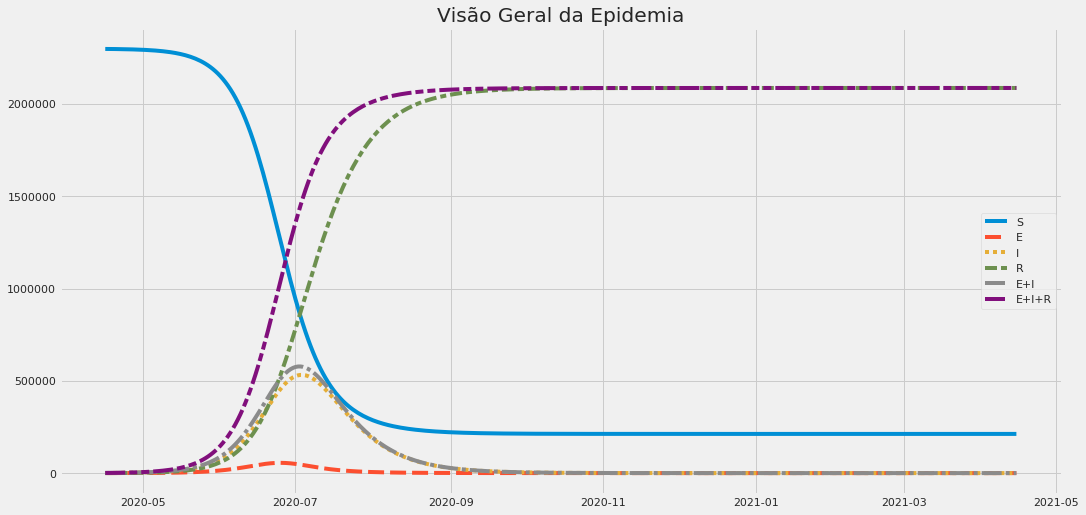

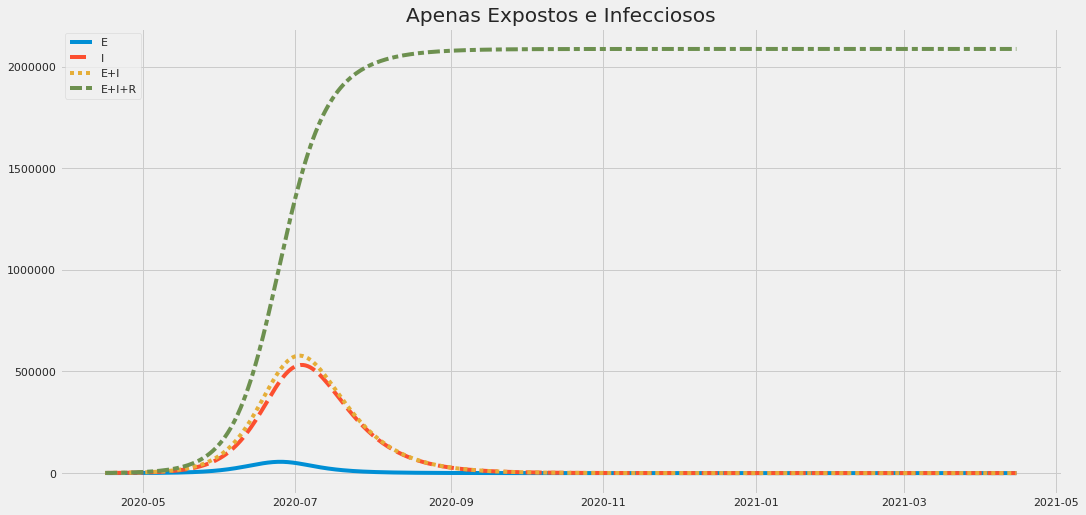

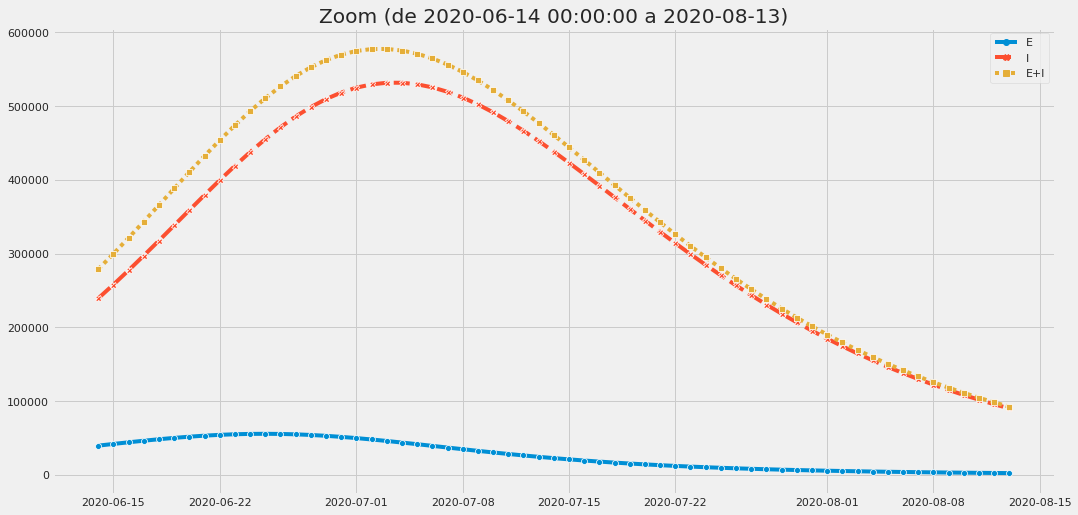

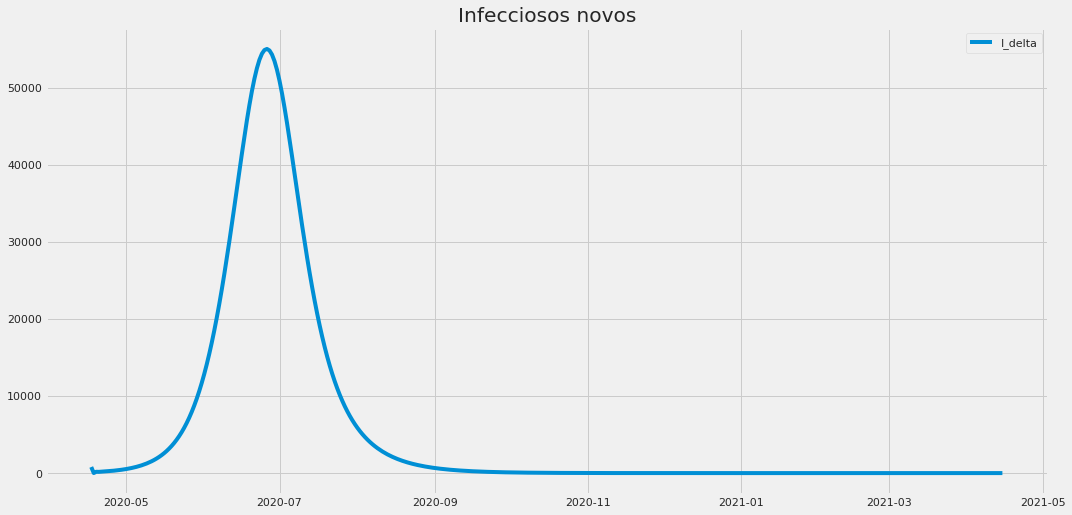

<Figure size 1152x576 with 0 Axes>

In [49]:
alpha = best['alpha']
beta  = best['beta']
gamma = best['gamma']

df_simulation_data = simulate(S=population_size - initially_infected, 
                              E=initially_infected,
                              I=0,
                              R=0, 
                              alpha=alpha, beta=beta, gamma=gamma, 
                              epidemic_start_date=epidemic_start_date, 
                              epidemic_duration_in_days=epidemic_duration_in_days, 
                              s_func=s, 
                              e_func=e,
                              i_func=i, 
                              r_func=r,
                              e_delta_func=e_delta,
                              i_delta_func=i_delta,
                              r_delta_func=r_delta)

plot_simulation_output(df_simulation_data)
df_simulation_data['2020-03-16':'2020-05-01'].head()

Como isso se compara visualmente com os dados reais observados?

In [50]:
df_data_target.tail()

,new_cases,new_deaths,total_cases,total_deaths,population,total_cases_ESTIMATED,total_cases_ESTIMATED_2,total_cases_ESTIMATED_FROM_SRAG
date,,,,,,,,
2020-04-30,173,3,453,14,2298696.0,NaN,6795,NaN
2020-05-01,64,0,517,14,2298696.0,NaN,7755,NaN
2020-05-02,84,0,601,14,2298696.0,NaN,9015,NaN
2020-05-03,129,0,730,14,2298696.0,NaN,10950,NaN
2020-05-04,0,0,730,14,2298696.0,NaN,10950,NaN


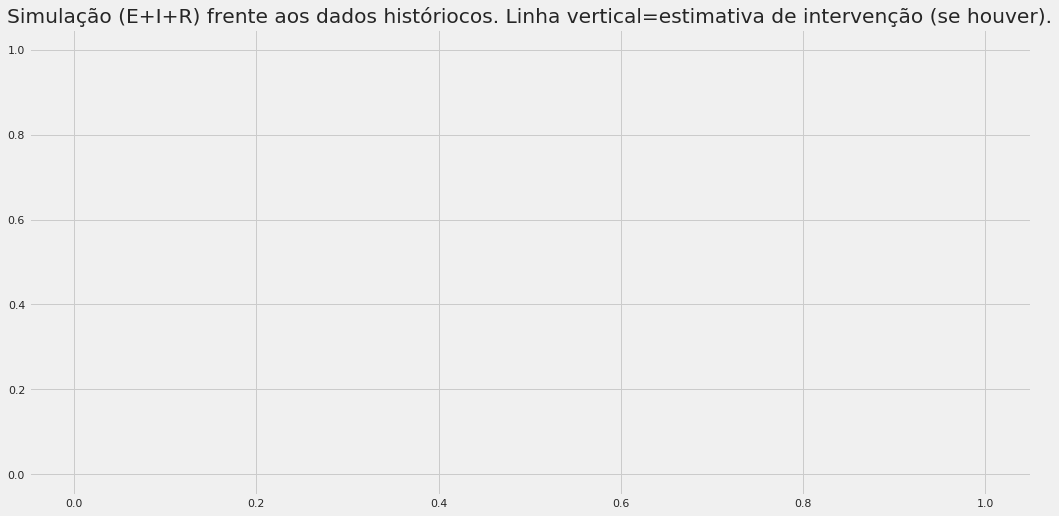

In [51]:
plot_curve_fitting(df_simulation_data=df_simulation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   comparison_date=pd.Timestamp('2020-04-01'),
                   best=best)

Salvemos os resultados.

In [52]:
df_simulation_data.to_csv(results_folder + f'seir_model_output.{target_location.lower()}.csv')

### Com Parâmetros Dinâmicos

Vamos experimentar agora introduzindo a possibilidade de aprender medidas de mitigação após o início do surto. Ou seja, experimentaremos com dois grupos de parâmetros: aqueles *antes* das medidas, e aqueles *depois* das medidas. Esses dois conjuntos de parâmetros serão estimados a partir dos dados fornecidos.

In [53]:
## assuming different gammas
#
#space = \
#    {'dynamic':\
#        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_1', 1.0, 10.0)}, 
#           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_2', 1.0, 10.0)},
#         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
#           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
#           'duration': hyperopt.hp.uniform('duration_3', 1.0, 10.0)}], 
#        0, 60)
#    }

# assuming gamma_1 == gamma_2 == gamma_3
space = \
    {'dynamic':\
        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
           'duration': hyperopt.hp.uniform('duration_1', 1.0, 20.0)}, 
           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_2', 1.0, 20.0)},
         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
           'duration': hyperopt.hp.uniform('duration_3', 1.0, 20.0)}], 
        0, 60)
    }

trials = hyperopt.Trials()
best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

print("Best parameters found:", best)

  0%|          | 0/3000 [00:00<?, ?trial/s, best loss=?]

  0%|          | 7/3000 [00:00<00:47, 62.98trial/s, best loss: 476.6492750859887]

  1%|          | 16/3000 [00:00<00:43, 68.23trial/s, best loss: 476.6492750859887]

  1%|          | 22/3000 [00:00<00:45, 65.26trial/s, best loss: 476.6492750859887]

  1%|          | 28/3000 [00:00<00:48, 61.15trial/s, best loss: 476.6492750859887]

  1%|          | 34/3000 [00:00<00:51, 57.46trial/s, best loss: 476.6492750859887]

  1%|▏         | 40/3000 [00:00<00:53, 55.25trial/s, best loss: 476.6492750859887]

  2%|▏         | 45/3000 [00:00<00:55, 53.21trial/s, best loss: 476.6492750859887]

  2%|▏         | 50/3000 [00:00<00:56, 51.97trial/s, best loss: 476.6492750859887]

  2%|▏         | 55/3000 [00:00<00:57, 51.30trial/s, best loss: 476.6492750859887]

  2%|▏         | 60/3000 [00:01<00:58, 50.03trial/s, best loss: 476.6492750859887]

  2%|▏         | 65/3000 [00:01<01:02, 47.21trial/s, best loss: 476.6492750859887]

  2%|▏         | 70/3000 [00:01<01:11, 40.81trial/s, best loss: 476.6492750859887]

  2%|▎         | 75/3000 [00:01<01:12, 40.37trial/s, best loss: 476.6492750859887]

  3%|▎         | 80/3000 [00:01<01:09, 41.99trial/s, best loss: 476.6492750859887]

  3%|▎         | 85/3000 [00:01<01:07, 43.04trial/s, best loss: 476.6492750859887]

  3%|▎         | 90/3000 [00:01<01:06, 43.81trial/s, best loss: 476.6492750859887]

  3%|▎         | 95/3000 [00:01<01:05, 44.28trial/s, best loss: 476.6492750859887]

  3%|▎         | 100/3000 [00:02<01:04, 45.08trial/s, best loss: 476.6492750859887]

  4%|▎         | 105/3000 [00:02<01:05, 44.32trial/s, best loss: 476.6492750859887]

  4%|▎         | 110/3000 [00:02<01:04, 44.71trial/s, best loss: 476.6492750859887]

  4%|▍         | 115/3000 [00:02<01:04, 44.85trial/s, best loss: 476.6492750859887]

  4%|▍         | 120/3000 [00:02<01:04, 44.84trial/s, best loss: 476.6492750859887]

  4%|▍         | 125/3000 [00:02<01:03, 44.93trial/s, best loss: 476.6492750859887]

  4%|▍         | 130/3000 [00:02<01:03, 45.05trial/s, best loss: 476.6492750859887]

  4%|▍         | 135/3000 [00:02<01:03, 45.02trial/s, best loss: 476.6492750859887]

  5%|▍         | 140/3000 [00:02<01:03, 44.72trial/s, best loss: 476.6492750859887]

  5%|▍         | 145/3000 [00:03<01:03, 44.92trial/s, best loss: 476.6492750859887]

  5%|▌         | 150/3000 [00:03<01:05, 43.45trial/s, best loss: 476.6492750859887]

  5%|▌         | 155/3000 [00:03<01:05, 43.23trial/s, best loss: 476.6492750859887]

  5%|▌         | 160/3000 [00:03<01:06, 42.79trial/s, best loss: 476.6492750859887]

  6%|▌         | 165/3000 [00:03<01:12, 38.90trial/s, best loss: 476.6492750859887]

  6%|▌         | 170/3000 [00:03<01:10, 40.14trial/s, best loss: 476.6492750859887]

  6%|▌         | 175/3000 [00:03<01:08, 41.03trial/s, best loss: 476.6492750859887]

  6%|▌         | 180/3000 [00:03<01:08, 41.43trial/s, best loss: 476.6492750859887]

  6%|▌         | 185/3000 [00:04<01:07, 41.61trial/s, best loss: 476.6492750859887]

  6%|▋         | 190/3000 [00:04<01:14, 37.80trial/s, best loss: 476.6492750859887]

  6%|▋         | 194/3000 [00:04<01:18, 35.76trial/s, best loss: 476.6492750859887]

  7%|▋         | 199/3000 [00:04<01:15, 37.30trial/s, best loss: 452.70004662493574]

  7%|▋         | 204/3000 [00:04<01:12, 38.50trial/s, best loss: 413.92588820027174]

  7%|▋         | 209/3000 [00:04<01:10, 39.65trial/s, best loss: 413.92588820027174]

  7%|▋         | 214/3000 [00:04<01:09, 40.18trial/s, best loss: 413.92588820027174]

  7%|▋         | 219/3000 [00:04<01:08, 40.47trial/s, best loss: 413.92588820027174]

  7%|▋         | 224/3000 [00:05<01:07, 40.97trial/s, best loss: 413.92588820027174]

  8%|▊         | 229/3000 [00:05<01:09, 39.79trial/s, best loss: 413.92588820027174]

  8%|▊         | 234/3000 [00:05<01:09, 39.96trial/s, best loss: 413.92588820027174]

  8%|▊         | 239/3000 [00:05<01:09, 39.56trial/s, best loss: 413.92588820027174]

  8%|▊         | 244/3000 [00:05<01:09, 39.81trial/s, best loss: 410.9461931528022] 

  8%|▊         | 249/3000 [00:05<01:08, 40.04trial/s, best loss: 410.9461931528022]

  8%|▊         | 254/3000 [00:05<01:08, 40.14trial/s, best loss: 410.9461931528022]

  9%|▊         | 259/3000 [00:05<01:08, 40.10trial/s, best loss: 410.9461931528022]

  9%|▉         | 264/3000 [00:06<01:07, 40.31trial/s, best loss: 410.9461931528022]

  9%|▉         | 269/3000 [00:06<01:08, 39.75trial/s, best loss: 410.9461931528022]

  9%|▉         | 273/3000 [00:06<01:08, 39.64trial/s, best loss: 410.9461931528022]

  9%|▉         | 277/3000 [00:06<01:09, 39.15trial/s, best loss: 372.76685680144703]

  9%|▉         | 281/3000 [00:06<01:09, 38.96trial/s, best loss: 372.76685680144703]

 10%|▉         | 285/3000 [00:06<01:09, 39.05trial/s, best loss: 372.76685680144703]

 10%|▉         | 289/3000 [00:06<01:09, 39.08trial/s, best loss: 372.76685680144703]

 10%|▉         | 293/3000 [00:06<01:09, 38.96trial/s, best loss: 372.76685680144703]

 10%|▉         | 297/3000 [00:06<01:09, 38.75trial/s, best loss: 372.76685680144703]

 10%|█         | 301/3000 [00:06<01:09, 38.78trial/s, best loss: 372.76685680144703]

 10%|█         | 305/3000 [00:07<01:09, 38.74trial/s, best loss: 372.76685680144703]

 10%|█         | 309/3000 [00:07<01:12, 37.27trial/s, best loss: 372.76685680144703]

 10%|█         | 313/3000 [00:07<01:13, 36.67trial/s, best loss: 372.76685680144703]

 11%|█         | 317/3000 [00:07<01:14, 35.96trial/s, best loss: 372.76685680144703]

 11%|█         | 321/3000 [00:07<01:20, 33.43trial/s, best loss: 372.76685680144703]

 11%|█         | 325/3000 [00:07<01:17, 34.63trial/s, best loss: 372.76685680144703]

 11%|█         | 329/3000 [00:07<01:15, 35.45trial/s, best loss: 372.76685680144703]

 11%|█         | 333/3000 [00:07<01:23, 31.89trial/s, best loss: 299.20893617597767]

 11%|█         | 337/3000 [00:08<01:19, 33.44trial/s, best loss: 299.20893617597767]

 11%|█▏        | 341/3000 [00:08<01:21, 32.61trial/s, best loss: 299.20893617597767]

 12%|█▏        | 345/3000 [00:08<01:21, 32.64trial/s, best loss: 299.20893617597767]

 12%|█▏        | 349/3000 [00:08<01:20, 33.02trial/s, best loss: 299.20893617597767]

 12%|█▏        | 353/3000 [00:08<01:20, 32.71trial/s, best loss: 299.20893617597767]

 12%|█▏        | 357/3000 [00:08<01:20, 32.69trial/s, best loss: 299.20893617597767]

 12%|█▏        | 361/3000 [00:08<01:20, 32.68trial/s, best loss: 299.20893617597767]

 12%|█▏        | 365/3000 [00:08<01:21, 32.51trial/s, best loss: 299.20893617597767]

 12%|█▏        | 369/3000 [00:09<01:21, 32.45trial/s, best loss: 299.20893617597767]

 12%|█▏        | 373/3000 [00:09<01:23, 31.46trial/s, best loss: 299.20893617597767]

 13%|█▎        | 377/3000 [00:09<01:24, 31.21trial/s, best loss: 299.20893617597767]

 13%|█▎        | 381/3000 [00:09<01:24, 30.90trial/s, best loss: 299.20893617597767]

 13%|█▎        | 385/3000 [00:09<01:24, 31.06trial/s, best loss: 299.20893617597767]

 13%|█▎        | 389/3000 [00:09<01:23, 31.27trial/s, best loss: 299.20893617597767]

 13%|█▎        | 393/3000 [00:09<01:22, 31.51trial/s, best loss: 299.20893617597767]

 13%|█▎        | 397/3000 [00:09<01:22, 31.55trial/s, best loss: 299.20893617597767]

 13%|█▎        | 401/3000 [00:10<01:31, 28.49trial/s, best loss: 299.20893617597767]

 14%|█▎        | 405/3000 [00:10<01:28, 29.37trial/s, best loss: 299.20893617597767]

 14%|█▎        | 409/3000 [00:10<01:26, 29.78trial/s, best loss: 299.20893617597767]

 14%|█▍        | 413/3000 [00:10<01:25, 30.19trial/s, best loss: 299.20893617597767]

 14%|█▍        | 417/3000 [00:10<01:24, 30.46trial/s, best loss: 299.20893617597767]

 14%|█▍        | 421/3000 [00:10<01:23, 30.75trial/s, best loss: 299.20893617597767]

 14%|█▍        | 425/3000 [00:10<01:23, 30.69trial/s, best loss: 299.20893617597767]

 14%|█▍        | 429/3000 [00:11<01:23, 30.76trial/s, best loss: 299.20893617597767]

 14%|█▍        | 433/3000 [00:11<01:26, 29.57trial/s, best loss: 299.20893617597767]

 15%|█▍        | 437/3000 [00:11<01:26, 29.77trial/s, best loss: 299.20893617597767]

 15%|█▍        | 441/3000 [00:11<01:24, 30.15trial/s, best loss: 299.20893617597767]

 15%|█▍        | 445/3000 [00:11<01:25, 30.02trial/s, best loss: 299.20893617597767]

 15%|█▍        | 449/3000 [00:11<01:24, 30.19trial/s, best loss: 299.20893617597767]

 15%|█▌        | 453/3000 [00:11<01:24, 30.31trial/s, best loss: 299.20893617597767]

 15%|█▌        | 457/3000 [00:11<01:23, 30.37trial/s, best loss: 299.20893617597767]

 15%|█▌        | 461/3000 [00:12<01:23, 30.30trial/s, best loss: 299.20893617597767]

 16%|█▌        | 465/3000 [00:12<01:25, 29.80trial/s, best loss: 299.20893617597767]

 16%|█▌        | 468/3000 [00:12<01:26, 29.19trial/s, best loss: 299.20893617597767]

 16%|█▌        | 472/3000 [00:12<01:26, 29.36trial/s, best loss: 299.20893617597767]

 16%|█▌        | 476/3000 [00:12<01:25, 29.59trial/s, best loss: 299.20893617597767]

 16%|█▌        | 479/3000 [00:12<01:24, 29.68trial/s, best loss: 299.20893617597767]

 16%|█▌        | 482/3000 [00:12<01:25, 29.62trial/s, best loss: 299.20893617597767]

 16%|█▌        | 485/3000 [00:12<01:25, 29.58trial/s, best loss: 299.20893617597767]

 16%|█▋        | 488/3000 [00:12<01:24, 29.64trial/s, best loss: 299.20893617597767]

 16%|█▋        | 491/3000 [00:13<01:25, 29.30trial/s, best loss: 299.20893617597767]

 16%|█▋        | 494/3000 [00:13<01:25, 29.18trial/s, best loss: 299.20893617597767]

 17%|█▋        | 497/3000 [00:13<01:37, 25.58trial/s, best loss: 299.20893617597767]

 17%|█▋        | 500/3000 [00:13<01:33, 26.72trial/s, best loss: 299.20893617597767]

 17%|█▋        | 503/3000 [00:13<01:30, 27.53trial/s, best loss: 299.20893617597767]

 17%|█▋        | 506/3000 [00:13<01:28, 28.20trial/s, best loss: 299.20893617597767]

 17%|█▋        | 509/3000 [00:13<01:27, 28.49trial/s, best loss: 299.20893617597767]

 17%|█▋        | 512/3000 [00:13<01:26, 28.65trial/s, best loss: 299.20893617597767]

 17%|█▋        | 515/3000 [00:13<01:26, 28.84trial/s, best loss: 299.20893617597767]

 17%|█▋        | 518/3000 [00:14<01:25, 29.00trial/s, best loss: 299.20893617597767]

 17%|█▋        | 521/3000 [00:14<01:27, 28.23trial/s, best loss: 299.20893617597767]

 17%|█▋        | 524/3000 [00:14<01:28, 28.05trial/s, best loss: 299.20893617597767]

 18%|█▊        | 527/3000 [00:14<01:28, 27.93trial/s, best loss: 299.20893617597767]

 18%|█▊        | 530/3000 [00:14<01:28, 27.87trial/s, best loss: 299.20893617597767]

 18%|█▊        | 533/3000 [00:14<01:28, 27.93trial/s, best loss: 299.20893617597767]

 18%|█▊        | 536/3000 [00:14<01:27, 28.01trial/s, best loss: 299.20893617597767]

 18%|█▊        | 539/3000 [00:14<01:27, 28.10trial/s, best loss: 299.20893617597767]

 18%|█▊        | 542/3000 [00:14<01:33, 26.37trial/s, best loss: 299.20893617597767]

 18%|█▊        | 545/3000 [00:15<01:32, 26.51trial/s, best loss: 299.20893617597767]

 18%|█▊        | 548/3000 [00:15<01:35, 25.75trial/s, best loss: 299.20893617597767]

 18%|█▊        | 551/3000 [00:15<01:33, 26.22trial/s, best loss: 299.20893617597767]

 18%|█▊        | 554/3000 [00:15<01:32, 26.49trial/s, best loss: 299.20893617597767]

 19%|█▊        | 557/3000 [00:15<01:30, 26.86trial/s, best loss: 299.20893617597767]

 19%|█▊        | 560/3000 [00:15<01:36, 25.28trial/s, best loss: 299.20893617597767]

 19%|█▉        | 563/3000 [00:15<01:33, 26.06trial/s, best loss: 299.20893617597767]

 19%|█▉        | 566/3000 [00:15<01:31, 26.62trial/s, best loss: 299.20893617597767]

 19%|█▉        | 569/3000 [00:15<01:30, 26.87trial/s, best loss: 299.20893617597767]

 19%|█▉        | 572/3000 [00:16<01:29, 27.12trial/s, best loss: 299.20893617597767]

 19%|█▉        | 575/3000 [00:16<01:33, 25.88trial/s, best loss: 299.20893617597767]

 19%|█▉        | 578/3000 [00:16<01:39, 24.42trial/s, best loss: 299.20893617597767]

 19%|█▉        | 581/3000 [00:16<01:35, 25.39trial/s, best loss: 299.20893617597767]

 19%|█▉        | 584/3000 [00:16<01:32, 26.10trial/s, best loss: 299.20893617597767]

 20%|█▉        | 587/3000 [00:16<01:30, 26.60trial/s, best loss: 299.20893617597767]

 20%|█▉        | 590/3000 [00:16<01:29, 26.83trial/s, best loss: 299.20893617597767]

 20%|█▉        | 593/3000 [00:16<01:29, 26.79trial/s, best loss: 299.20893617597767]

 20%|█▉        | 596/3000 [00:17<01:29, 26.95trial/s, best loss: 299.20893617597767]

 20%|█▉        | 599/3000 [00:17<01:29, 26.69trial/s, best loss: 299.20893617597767]

 20%|██        | 602/3000 [00:17<01:29, 26.86trial/s, best loss: 299.20893617597767]

 20%|██        | 605/3000 [00:17<01:29, 26.75trial/s, best loss: 299.20893617597767]

 20%|██        | 608/3000 [00:17<01:28, 26.88trial/s, best loss: 299.20893617597767]

 20%|██        | 611/3000 [00:17<01:28, 26.94trial/s, best loss: 299.20893617597767]

 20%|██        | 614/3000 [00:17<01:28, 27.08trial/s, best loss: 299.20893617597767]

 21%|██        | 617/3000 [00:17<01:28, 26.93trial/s, best loss: 299.20893617597767]

 21%|██        | 620/3000 [00:17<01:30, 26.31trial/s, best loss: 299.20893617597767]

 21%|██        | 623/3000 [00:18<01:30, 26.38trial/s, best loss: 299.20893617597767]

 21%|██        | 626/3000 [00:18<01:34, 25.22trial/s, best loss: 299.20893617597767]

 21%|██        | 629/3000 [00:18<01:32, 25.62trial/s, best loss: 299.20893617597767]

 21%|██        | 632/3000 [00:18<01:33, 25.37trial/s, best loss: 299.20893617597767]

 21%|██        | 635/3000 [00:18<01:31, 25.83trial/s, best loss: 299.20893617597767]

 21%|██▏       | 638/3000 [00:18<01:30, 26.17trial/s, best loss: 299.20893617597767]

 21%|██▏       | 641/3000 [00:18<01:30, 26.06trial/s, best loss: 299.20893617597767]

 21%|██▏       | 644/3000 [00:18<01:30, 26.05trial/s, best loss: 299.20893617597767]

 22%|██▏       | 647/3000 [00:18<01:30, 25.94trial/s, best loss: 299.20893617597767]

 22%|██▏       | 650/3000 [00:19<01:30, 26.02trial/s, best loss: 299.20893617597767]

 22%|██▏       | 653/3000 [00:19<01:32, 25.24trial/s, best loss: 299.20893617597767]

 22%|██▏       | 656/3000 [00:19<01:32, 25.36trial/s, best loss: 299.20893617597767]

 22%|██▏       | 659/3000 [00:19<01:32, 25.27trial/s, best loss: 299.20893617597767]

 22%|██▏       | 662/3000 [00:19<01:32, 25.39trial/s, best loss: 299.20893617597767]

 22%|██▏       | 665/3000 [00:19<01:31, 25.57trial/s, best loss: 299.20893617597767]

 22%|██▏       | 668/3000 [00:19<01:31, 25.52trial/s, best loss: 299.20893617597767]

 22%|██▏       | 671/3000 [00:19<01:31, 25.49trial/s, best loss: 299.20893617597767]

 22%|██▏       | 674/3000 [00:20<01:41, 22.94trial/s, best loss: 299.20893617597767]

 23%|██▎       | 677/3000 [00:20<01:41, 22.88trial/s, best loss: 299.20893617597767]

 23%|██▎       | 680/3000 [00:20<01:38, 23.46trial/s, best loss: 299.20893617597767]

 23%|██▎       | 683/3000 [00:20<01:37, 23.86trial/s, best loss: 299.20893617597767]

 23%|██▎       | 686/3000 [00:20<01:35, 24.24trial/s, best loss: 299.20893617597767]

 23%|██▎       | 689/3000 [00:20<01:33, 24.67trial/s, best loss: 299.20893617597767]

 23%|██▎       | 692/3000 [00:20<01:32, 24.90trial/s, best loss: 299.20893617597767]

 23%|██▎       | 695/3000 [00:20<01:32, 24.94trial/s, best loss: 299.20893617597767]

 23%|██▎       | 698/3000 [00:21<01:31, 25.12trial/s, best loss: 299.20893617597767]

 23%|██▎       | 701/3000 [00:21<01:34, 24.45trial/s, best loss: 299.20893617597767]

 23%|██▎       | 704/3000 [00:21<01:34, 24.32trial/s, best loss: 299.20893617597767]

 24%|██▎       | 707/3000 [00:21<01:35, 24.04trial/s, best loss: 299.20893617597767]

 24%|██▎       | 710/3000 [00:21<01:37, 23.59trial/s, best loss: 299.20893617597767]

 24%|██▍       | 713/3000 [00:21<01:36, 23.65trial/s, best loss: 299.20893617597767]

 24%|██▍       | 716/3000 [00:21<01:34, 24.05trial/s, best loss: 299.20893617597767]

 24%|██▍       | 719/3000 [00:21<01:33, 24.42trial/s, best loss: 299.20893617597767]

 24%|██▍       | 722/3000 [00:22<01:32, 24.56trial/s, best loss: 299.20893617597767]

 24%|██▍       | 725/3000 [00:22<01:38, 23.19trial/s, best loss: 299.20893617597767]

 24%|██▍       | 728/3000 [00:22<01:36, 23.52trial/s, best loss: 299.20893617597767]

 24%|██▍       | 731/3000 [00:22<01:34, 23.96trial/s, best loss: 299.20893617597767]

 24%|██▍       | 734/3000 [00:22<01:33, 24.20trial/s, best loss: 299.20893617597767]

 25%|██▍       | 737/3000 [00:22<01:32, 24.41trial/s, best loss: 299.20893617597767]

 25%|██▍       | 740/3000 [00:22<01:32, 24.53trial/s, best loss: 299.20893617597767]

 25%|██▍       | 743/3000 [00:22<01:31, 24.56trial/s, best loss: 299.20893617597767]

 25%|██▍       | 746/3000 [00:23<01:31, 24.72trial/s, best loss: 299.20893617597767]

 25%|██▍       | 749/3000 [00:23<01:33, 24.16trial/s, best loss: 299.20893617597767]

 25%|██▌       | 752/3000 [00:23<01:33, 24.16trial/s, best loss: 299.20893617597767]

 25%|██▌       | 755/3000 [00:23<01:33, 24.11trial/s, best loss: 299.20893617597767]

 25%|██▌       | 758/3000 [00:23<01:32, 24.17trial/s, best loss: 299.20893617597767]

 25%|██▌       | 761/3000 [00:23<01:32, 24.19trial/s, best loss: 299.20893617597767]

 25%|██▌       | 764/3000 [00:23<01:31, 24.32trial/s, best loss: 299.20893617597767]

 26%|██▌       | 767/3000 [00:23<01:31, 24.36trial/s, best loss: 299.20893617597767]

 26%|██▌       | 770/3000 [00:24<01:31, 24.44trial/s, best loss: 299.20893617597767]

 26%|██▌       | 773/3000 [00:24<01:33, 23.75trial/s, best loss: 299.20893617597767]

 26%|██▌       | 776/3000 [00:24<01:33, 23.73trial/s, best loss: 299.20893617597767]

 26%|██▌       | 779/3000 [00:24<01:34, 23.47trial/s, best loss: 299.20893617597767]

 26%|██▌       | 782/3000 [00:24<01:34, 23.47trial/s, best loss: 299.20893617597767]

 26%|██▌       | 785/3000 [00:24<01:34, 23.55trial/s, best loss: 299.20893617597767]

 26%|██▋       | 788/3000 [00:24<01:33, 23.59trial/s, best loss: 299.20893617597767]

 26%|██▋       | 791/3000 [00:24<01:33, 23.62trial/s, best loss: 299.20893617597767]

 26%|██▋       | 794/3000 [00:25<01:43, 21.33trial/s, best loss: 299.20893617597767]

 27%|██▋       | 797/3000 [00:25<01:42, 21.40trial/s, best loss: 299.20893617597767]

 27%|██▋       | 800/3000 [00:25<01:41, 21.75trial/s, best loss: 299.20893617597767]

 27%|██▋       | 803/3000 [00:25<01:38, 22.27trial/s, best loss: 299.20893617597767]

 27%|██▋       | 806/3000 [00:25<01:37, 22.58trial/s, best loss: 299.20893617597767]

 27%|██▋       | 809/3000 [00:25<01:35, 22.85trial/s, best loss: 299.20893617597767]

 27%|██▋       | 812/3000 [00:25<01:36, 22.76trial/s, best loss: 299.20893617597767]

 27%|██▋       | 815/3000 [00:26<01:35, 22.91trial/s, best loss: 299.20893617597767]

 27%|██▋       | 818/3000 [00:26<01:38, 22.07trial/s, best loss: 299.20893617597767]

 27%|██▋       | 821/3000 [00:26<01:37, 22.40trial/s, best loss: 299.20893617597767]

 27%|██▋       | 824/3000 [00:26<01:36, 22.64trial/s, best loss: 299.20893617597767]

 28%|██▊       | 827/3000 [00:26<01:35, 22.79trial/s, best loss: 299.20893617597767]

 28%|██▊       | 830/3000 [00:26<01:34, 22.99trial/s, best loss: 299.20893617597767]

 28%|██▊       | 833/3000 [00:26<01:34, 22.97trial/s, best loss: 299.20893617597767]

 28%|██▊       | 836/3000 [00:26<01:35, 22.56trial/s, best loss: 299.20893617597767]

 28%|██▊       | 839/3000 [00:27<01:36, 22.39trial/s, best loss: 299.20893617597767]

 28%|██▊       | 842/3000 [00:27<01:39, 21.65trial/s, best loss: 299.20893617597767]

 28%|██▊       | 845/3000 [00:27<01:44, 20.70trial/s, best loss: 299.20893617597767]

 28%|██▊       | 848/3000 [00:27<01:42, 20.90trial/s, best loss: 299.20893617597767]

 28%|██▊       | 851/3000 [00:27<01:41, 21.09trial/s, best loss: 299.20893617597767]

 28%|██▊       | 854/3000 [00:27<01:40, 21.29trial/s, best loss: 299.20893617597767]

 29%|██▊       | 857/3000 [00:27<01:40, 21.30trial/s, best loss: 299.20893617597767]

 29%|██▊       | 860/3000 [00:28<01:40, 21.32trial/s, best loss: 299.20893617597767]

 29%|██▉       | 863/3000 [00:28<01:41, 21.03trial/s, best loss: 299.20893617597767]

 29%|██▉       | 866/3000 [00:28<01:42, 20.90trial/s, best loss: 299.20893617597767]

 29%|██▉       | 869/3000 [00:28<01:40, 21.31trial/s, best loss: 299.20893617597767]

 29%|██▉       | 872/3000 [00:28<01:39, 21.40trial/s, best loss: 299.20893617597767]

 29%|██▉       | 875/3000 [00:28<01:39, 21.26trial/s, best loss: 299.20893617597767]

 29%|██▉       | 878/3000 [00:28<01:40, 21.05trial/s, best loss: 299.20893617597767]

 29%|██▉       | 881/3000 [00:29<01:38, 21.51trial/s, best loss: 299.20893617597767]

 29%|██▉       | 884/3000 [00:29<01:39, 21.20trial/s, best loss: 299.20893617597767]

 30%|██▉       | 887/3000 [00:29<01:39, 21.28trial/s, best loss: 299.20893617597767]

 30%|██▉       | 890/3000 [00:29<01:38, 21.45trial/s, best loss: 299.20893617597767]

 30%|██▉       | 893/3000 [00:29<01:37, 21.64trial/s, best loss: 299.20893617597767]

 30%|██▉       | 896/3000 [00:29<01:36, 21.81trial/s, best loss: 299.20893617597767]

 30%|██▉       | 899/3000 [00:29<01:36, 21.88trial/s, best loss: 299.20893617597767]

 30%|███       | 902/3000 [00:30<01:35, 21.99trial/s, best loss: 299.20893617597767]

 30%|███       | 905/3000 [00:30<01:37, 21.44trial/s, best loss: 299.20893617597767]

 30%|███       | 908/3000 [00:30<01:39, 20.96trial/s, best loss: 299.20893617597767]

 30%|███       | 911/3000 [00:30<01:39, 21.01trial/s, best loss: 299.20893617597767]

 30%|███       | 914/3000 [00:30<01:37, 21.48trial/s, best loss: 299.20893617597767]

 31%|███       | 917/3000 [00:30<01:35, 21.79trial/s, best loss: 299.20893617597767]

 31%|███       | 920/3000 [00:30<01:34, 21.91trial/s, best loss: 299.20893617597767]

 31%|███       | 923/3000 [00:31<01:34, 21.93trial/s, best loss: 299.20893617597767]

 31%|███       | 926/3000 [00:31<01:37, 21.38trial/s, best loss: 299.20893617597767]

 31%|███       | 929/3000 [00:31<01:47, 19.23trial/s, best loss: 299.20893617597767]

 31%|███       | 932/3000 [00:31<01:43, 20.05trial/s, best loss: 299.20893617597767]

 31%|███       | 935/3000 [00:31<01:52, 18.32trial/s, best loss: 299.20893617597767]

 31%|███▏      | 938/3000 [00:31<01:47, 19.14trial/s, best loss: 299.20893617597767]

 31%|███▏      | 941/3000 [00:31<01:44, 19.73trial/s, best loss: 299.20893617597767]

 31%|███▏      | 944/3000 [00:32<01:43, 19.81trial/s, best loss: 299.20893617597767]

 32%|███▏      | 947/3000 [00:32<01:44, 19.59trial/s, best loss: 299.20893617597767]

 32%|███▏      | 949/3000 [00:32<01:45, 19.46trial/s, best loss: 299.20893617597767]

 32%|███▏      | 952/3000 [00:32<01:44, 19.62trial/s, best loss: 299.20893617597767]

 32%|███▏      | 954/3000 [00:32<01:43, 19.70trial/s, best loss: 299.20893617597767]

 32%|███▏      | 956/3000 [00:32<01:43, 19.72trial/s, best loss: 299.20893617597767]

 32%|███▏      | 959/3000 [00:32<01:41, 20.06trial/s, best loss: 299.20893617597767]

 32%|███▏      | 962/3000 [00:33<01:40, 20.37trial/s, best loss: 299.20893617597767]

 32%|███▏      | 965/3000 [00:33<01:41, 20.08trial/s, best loss: 299.20893617597767]

 32%|███▏      | 968/3000 [00:33<01:43, 19.63trial/s, best loss: 299.20893617597767]

 32%|███▏      | 970/3000 [00:33<01:43, 19.66trial/s, best loss: 299.20893617597767]

 32%|███▏      | 973/3000 [00:33<01:42, 19.86trial/s, best loss: 299.20893617597767]

 33%|███▎      | 976/3000 [00:33<01:47, 18.87trial/s, best loss: 299.20893617597767]

 33%|███▎      | 978/3000 [00:33<01:53, 17.82trial/s, best loss: 299.20893617597767]

 33%|███▎      | 981/3000 [00:34<01:48, 18.58trial/s, best loss: 299.20893617597767]

 33%|███▎      | 983/3000 [00:34<01:48, 18.63trial/s, best loss: 299.20893617597767]

 33%|███▎      | 986/3000 [00:34<01:44, 19.18trial/s, best loss: 299.20893617597767]

 33%|███▎      | 988/3000 [00:34<01:44, 19.24trial/s, best loss: 299.20893617597767]

 33%|███▎      | 990/3000 [00:34<01:44, 19.31trial/s, best loss: 299.20893617597767]

 33%|███▎      | 993/3000 [00:34<01:41, 19.73trial/s, best loss: 299.20893617597767]

 33%|███▎      | 996/3000 [00:34<01:40, 19.93trial/s, best loss: 299.20893617597767]

 33%|███▎      | 998/3000 [00:34<01:40, 19.92trial/s, best loss: 299.20893617597767]

 33%|███▎      | 1001/3000 [00:35<01:39, 20.05trial/s, best loss: 299.20893617597767]

 33%|███▎      | 1004/3000 [00:35<01:41, 19.76trial/s, best loss: 299.20893617597767]

 34%|███▎      | 1007/3000 [00:35<01:40, 19.83trial/s, best loss: 299.20893617597767]

 34%|███▎      | 1009/3000 [00:35<01:40, 19.81trial/s, best loss: 299.20893617597767]

 34%|███▎      | 1012/3000 [00:35<01:39, 20.00trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1015/3000 [00:35<01:38, 20.08trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1018/3000 [00:35<01:38, 20.13trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1021/3000 [00:36<01:38, 20.12trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1024/3000 [00:36<01:39, 19.92trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1027/3000 [00:36<01:39, 19.84trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1029/3000 [00:36<01:39, 19.85trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1032/3000 [00:36<01:38, 19.97trial/s, best loss: 299.20893617597767]

 34%|███▍      | 1035/3000 [00:36<01:37, 20.12trial/s, best loss: 299.20893617597767]

 35%|███▍      | 1038/3000 [00:36<01:37, 20.12trial/s, best loss: 299.20893617597767]

 35%|███▍      | 1041/3000 [00:37<01:37, 20.15trial/s, best loss: 299.20893617597767]

 35%|███▍      | 1044/3000 [00:37<01:39, 19.57trial/s, best loss: 299.20893617597767]

 35%|███▍      | 1046/3000 [00:37<01:39, 19.69trial/s, best loss: 299.20893617597767]

 35%|███▍      | 1048/3000 [00:37<01:40, 19.44trial/s, best loss: 299.20893617597767]

 35%|███▌      | 1051/3000 [00:37<01:39, 19.66trial/s, best loss: 299.20893617597767]

 35%|███▌      | 1053/3000 [00:37<01:38, 19.75trial/s, best loss: 299.20893617597767]

 35%|███▌      | 1056/3000 [00:37<01:37, 19.87trial/s, best loss: 299.20893617597767]

 35%|███▌      | 1058/3000 [00:37<01:38, 19.64trial/s, best loss: 299.20893617597767]

 35%|███▌      | 1060/3000 [00:38<01:38, 19.69trial/s, best loss: 299.20893617597767]

 35%|███▌      | 1062/3000 [00:38<01:39, 19.45trial/s, best loss: 299.20893617597767]

 35%|███▌      | 1064/3000 [00:38<01:39, 19.43trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1066/3000 [00:38<01:41, 19.13trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1068/3000 [00:38<01:40, 19.31trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1070/3000 [00:38<01:42, 18.74trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1073/3000 [00:38<01:40, 19.19trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1075/3000 [00:38<01:39, 19.39trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1077/3000 [00:38<01:51, 17.31trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1080/3000 [00:39<01:45, 18.21trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1082/3000 [00:39<01:45, 18.19trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1085/3000 [00:39<01:42, 18.73trial/s, best loss: 299.20893617597767]

 36%|███▌      | 1087/3000 [00:39<01:40, 19.02trial/s, best loss: 299.20893617597767]

 36%|███▋      | 1090/3000 [00:39<01:38, 19.40trial/s, best loss: 286.2693069126083] 

 36%|███▋      | 1092/3000 [00:39<01:37, 19.56trial/s, best loss: 286.2693069126083]

 36%|███▋      | 1094/3000 [00:39<01:37, 19.51trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1096/3000 [00:39<01:37, 19.58trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1098/3000 [00:39<01:36, 19.63trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1100/3000 [00:40<01:37, 19.53trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1102/3000 [00:40<01:41, 18.71trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1104/3000 [00:40<01:40, 18.86trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1106/3000 [00:40<01:39, 19.02trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1108/3000 [00:40<01:39, 19.01trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1110/3000 [00:40<01:38, 19.14trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1112/3000 [00:40<01:38, 19.22trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1114/3000 [00:40<01:50, 17.10trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1116/3000 [00:40<01:46, 17.70trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1118/3000 [00:41<01:42, 18.30trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1120/3000 [00:41<01:46, 17.70trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1122/3000 [00:41<01:44, 17.93trial/s, best loss: 286.2693069126083]

 37%|███▋      | 1124/3000 [00:41<01:43, 18.07trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1126/3000 [00:41<01:42, 18.37trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1128/3000 [00:41<01:40, 18.57trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1130/3000 [00:41<01:41, 18.42trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1132/3000 [00:41<01:49, 17.06trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1134/3000 [00:41<01:46, 17.54trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1137/3000 [00:42<01:43, 17.96trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1139/3000 [00:42<01:42, 18.24trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1141/3000 [00:42<01:41, 18.31trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1143/3000 [00:42<01:42, 18.14trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1145/3000 [00:42<01:40, 18.45trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1147/3000 [00:42<01:38, 18.81trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1149/3000 [00:42<01:37, 18.91trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1151/3000 [00:42<01:36, 19.22trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1153/3000 [00:42<01:36, 19.15trial/s, best loss: 286.2693069126083]

 38%|███▊      | 1155/3000 [00:43<01:35, 19.30trial/s, best loss: 286.2693069126083]

 39%|███▊      | 1157/3000 [00:43<01:41, 18.24trial/s, best loss: 286.2693069126083]

 39%|███▊      | 1159/3000 [00:43<01:39, 18.49trial/s, best loss: 286.2693069126083]

 39%|███▊      | 1161/3000 [00:43<01:38, 18.76trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1163/3000 [00:43<01:36, 19.06trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1165/3000 [00:43<01:35, 19.26trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1167/3000 [00:43<01:35, 19.24trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1169/3000 [00:43<01:48, 16.88trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1171/3000 [00:43<01:45, 17.30trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1173/3000 [00:44<01:42, 17.85trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1175/3000 [00:44<01:42, 17.79trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1177/3000 [00:44<01:42, 17.82trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1179/3000 [00:44<01:42, 17.79trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1181/3000 [00:44<01:41, 17.95trial/s, best loss: 286.2693069126083]

 39%|███▉      | 1183/3000 [00:44<01:39, 18.23trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1185/3000 [00:44<01:39, 18.33trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1187/3000 [00:44<01:37, 18.52trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1189/3000 [00:44<01:38, 18.40trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1191/3000 [00:45<01:37, 18.47trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1193/3000 [00:45<01:42, 17.67trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1195/3000 [00:45<01:41, 17.77trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1197/3000 [00:45<01:39, 18.06trial/s, best loss: 286.2693069126083]

 40%|███▉      | 1199/3000 [00:45<01:38, 18.28trial/s, best loss: 286.2693069126083]

 40%|████      | 1201/3000 [00:45<01:37, 18.44trial/s, best loss: 286.2693069126083]

 40%|████      | 1203/3000 [00:45<01:37, 18.52trial/s, best loss: 286.2693069126083]

 40%|████      | 1205/3000 [00:45<01:37, 18.44trial/s, best loss: 286.2693069126083]

 40%|████      | 1207/3000 [00:45<01:38, 18.22trial/s, best loss: 286.2693069126083]

 40%|████      | 1209/3000 [00:46<01:37, 18.44trial/s, best loss: 286.2693069126083]

 40%|████      | 1211/3000 [00:46<01:37, 18.26trial/s, best loss: 286.2693069126083]

 40%|████      | 1213/3000 [00:46<01:36, 18.48trial/s, best loss: 286.2693069126083]

 40%|████      | 1215/3000 [00:46<01:37, 18.29trial/s, best loss: 286.2693069126083]

 41%|████      | 1217/3000 [00:46<01:36, 18.44trial/s, best loss: 286.2693069126083]

 41%|████      | 1219/3000 [00:46<01:35, 18.64trial/s, best loss: 286.2693069126083]

 41%|████      | 1221/3000 [00:46<01:35, 18.58trial/s, best loss: 286.2693069126083]

 41%|████      | 1223/3000 [00:46<01:34, 18.72trial/s, best loss: 286.2693069126083]

 41%|████      | 1225/3000 [00:46<01:37, 18.25trial/s, best loss: 286.2693069126083]

 41%|████      | 1227/3000 [00:47<01:38, 18.01trial/s, best loss: 286.2693069126083]

 41%|████      | 1229/3000 [00:47<01:43, 17.05trial/s, best loss: 286.2693069126083]

 41%|████      | 1231/3000 [00:47<01:42, 17.34trial/s, best loss: 286.2693069126083]

 41%|████      | 1233/3000 [00:47<01:41, 17.46trial/s, best loss: 286.2693069126083]

 41%|████      | 1235/3000 [00:47<01:39, 17.75trial/s, best loss: 286.2693069126083]

 41%|████      | 1237/3000 [00:47<01:37, 18.05trial/s, best loss: 286.2693069126083]

 41%|████▏     | 1239/3000 [00:47<01:36, 18.29trial/s, best loss: 286.2693069126083]

 41%|████▏     | 1241/3000 [00:47<01:35, 18.47trial/s, best loss: 286.2693069126083]

 41%|████▏     | 1243/3000 [00:47<01:37, 18.01trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1245/3000 [00:48<01:37, 17.93trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1247/3000 [00:48<01:38, 17.75trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1249/3000 [00:48<01:37, 17.93trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1251/3000 [00:48<01:41, 17.27trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1253/3000 [00:48<01:52, 15.57trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1255/3000 [00:48<01:46, 16.38trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1257/3000 [00:48<01:42, 16.94trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1259/3000 [00:48<01:40, 17.39trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1261/3000 [00:48<01:37, 17.78trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1263/3000 [00:49<01:36, 17.91trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1265/3000 [00:49<01:36, 17.89trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1267/3000 [00:49<01:35, 18.07trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1269/3000 [00:49<01:35, 18.13trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1271/3000 [00:49<01:34, 18.30trial/s, best loss: 286.2693069126083]

 42%|████▏     | 1273/3000 [00:49<01:33, 18.45trial/s, best loss: 286.2693069126083]

 42%|████▎     | 1275/3000 [00:49<01:33, 18.53trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1277/3000 [00:49<01:33, 18.49trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1279/3000 [00:49<01:33, 18.48trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1281/3000 [00:50<01:32, 18.63trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1283/3000 [00:50<01:35, 17.99trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1285/3000 [00:50<01:34, 18.07trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1287/3000 [00:50<01:35, 17.99trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1289/3000 [00:50<01:46, 16.00trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1291/3000 [00:50<01:43, 16.56trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1293/3000 [00:50<01:41, 16.88trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1295/3000 [00:50<01:39, 17.12trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1297/3000 [00:51<01:38, 17.34trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1299/3000 [00:51<01:42, 16.62trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1301/3000 [00:51<01:41, 16.82trial/s, best loss: 286.2693069126083]

 43%|████▎     | 1303/3000 [00:51<01:41, 16.77trial/s, best loss: 286.2693069126083]

 44%|████▎     | 1305/3000 [00:51<01:39, 17.05trial/s, best loss: 286.2693069126083]

 44%|████▎     | 1307/3000 [00:51<01:37, 17.31trial/s, best loss: 286.2693069126083]

 44%|████▎     | 1309/3000 [00:51<01:37, 17.38trial/s, best loss: 286.2693069126083]

 44%|████▎     | 1311/3000 [00:51<01:37, 17.31trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1313/3000 [00:51<01:36, 17.50trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1315/3000 [00:52<01:35, 17.70trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1317/3000 [00:52<01:41, 16.62trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1319/3000 [00:52<01:39, 16.90trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1321/3000 [00:52<01:37, 17.16trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1323/3000 [00:52<01:37, 17.24trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1325/3000 [00:52<01:36, 17.42trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1327/3000 [00:52<01:35, 17.45trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1329/3000 [00:52<01:35, 17.50trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1331/3000 [00:52<01:34, 17.63trial/s, best loss: 286.2693069126083]

 44%|████▍     | 1333/3000 [00:53<01:37, 17.14trial/s, best loss: 272.5722181034353]

 44%|████▍     | 1335/3000 [00:53<01:35, 17.36trial/s, best loss: 272.5722181034353]

 45%|████▍     | 1337/3000 [00:53<01:36, 17.28trial/s, best loss: 272.5722181034353]

 45%|████▍     | 1339/3000 [00:53<01:35, 17.35trial/s, best loss: 272.5722181034353]

 45%|████▍     | 1341/3000 [00:53<01:35, 17.44trial/s, best loss: 272.5722181034353]

 45%|████▍     | 1343/3000 [00:53<01:35, 17.41trial/s, best loss: 272.5722181034353]

 45%|████▍     | 1345/3000 [00:53<01:34, 17.46trial/s, best loss: 272.5722181034353]

 45%|████▍     | 1347/3000 [00:53<01:34, 17.53trial/s, best loss: 272.5722181034353]

 45%|████▍     | 1349/3000 [00:54<01:32, 17.81trial/s, best loss: 272.5722181034353]

 45%|████▌     | 1351/3000 [00:54<01:32, 17.75trial/s, best loss: 272.5722181034353]

 45%|████▌     | 1353/3000 [00:54<01:32, 17.87trial/s, best loss: 272.5722181034353]

 45%|████▌     | 1355/3000 [00:54<01:33, 17.60trial/s, best loss: 272.5722181034353]

 45%|████▌     | 1357/3000 [00:54<01:34, 17.38trial/s, best loss: 272.5722181034353]

 45%|████▌     | 1359/3000 [00:54<01:34, 17.45trial/s, best loss: 272.5722181034353]

 45%|████▌     | 1361/3000 [00:54<01:33, 17.45trial/s, best loss: 272.5722181034353]

 45%|████▌     | 1363/3000 [00:54<01:33, 17.45trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1365/3000 [00:54<01:34, 17.34trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1367/3000 [00:55<01:34, 17.35trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1369/3000 [00:55<01:39, 16.39trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1371/3000 [00:55<01:38, 16.62trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1373/3000 [00:55<01:48, 15.01trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1375/3000 [00:55<01:43, 15.75trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1377/3000 [00:55<01:39, 16.28trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1379/3000 [00:55<01:36, 16.74trial/s, best loss: 272.5722181034353]

 46%|████▌     | 1381/3000 [00:55<01:35, 16.95trial/s, best loss: 247.45919699874432]

 46%|████▌     | 1383/3000 [00:56<01:34, 17.16trial/s, best loss: 247.45919699874432]

 46%|████▌     | 1385/3000 [00:56<01:36, 16.80trial/s, best loss: 247.45919699874432]

 46%|████▌     | 1387/3000 [00:56<01:34, 17.13trial/s, best loss: 247.45919699874432]

 46%|████▋     | 1389/3000 [00:56<01:33, 17.24trial/s, best loss: 247.45919699874432]

 46%|████▋     | 1391/3000 [00:56<01:32, 17.32trial/s, best loss: 247.45919699874432]

 46%|████▋     | 1393/3000 [00:56<01:32, 17.40trial/s, best loss: 247.45919699874432]

 46%|████▋     | 1395/3000 [00:56<01:31, 17.51trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1397/3000 [00:56<01:31, 17.60trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1399/3000 [00:56<01:31, 17.57trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1401/3000 [00:57<01:31, 17.43trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1403/3000 [00:57<01:35, 16.70trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1405/3000 [00:57<01:35, 16.70trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1407/3000 [00:57<01:47, 14.85trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1409/3000 [00:57<01:42, 15.58trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1411/3000 [00:57<01:38, 16.14trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1413/3000 [00:57<01:35, 16.55trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1415/3000 [00:57<01:35, 16.67trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1417/3000 [00:58<01:33, 16.98trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1419/3000 [00:58<01:33, 16.97trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1421/3000 [00:58<01:32, 17.07trial/s, best loss: 247.45919699874432]

 47%|████▋     | 1423/3000 [00:58<01:32, 17.02trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1425/3000 [00:58<01:31, 17.17trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1427/3000 [00:58<01:31, 17.27trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1429/3000 [00:58<01:31, 17.18trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1431/3000 [00:58<01:32, 17.02trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1433/3000 [00:59<01:32, 16.90trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1435/3000 [00:59<01:35, 16.43trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1437/3000 [00:59<01:34, 16.58trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1439/3000 [00:59<01:34, 16.48trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1441/3000 [00:59<01:34, 16.44trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1443/3000 [00:59<01:34, 16.52trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1445/3000 [00:59<01:33, 16.66trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1447/3000 [00:59<01:32, 16.87trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1449/3000 [00:59<01:31, 16.93trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1451/3000 [01:00<01:48, 14.31trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1453/3000 [01:00<01:46, 14.46trial/s, best loss: 247.45919699874432]

 48%|████▊     | 1455/3000 [01:00<01:43, 14.89trial/s, best loss: 247.45919699874432]

 49%|████▊     | 1457/3000 [01:00<01:40, 15.30trial/s, best loss: 247.45919699874432]

 49%|████▊     | 1459/3000 [01:00<01:37, 15.82trial/s, best loss: 247.45919699874432]

 49%|████▊     | 1461/3000 [01:00<01:35, 16.14trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1463/3000 [01:00<01:33, 16.43trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1465/3000 [01:01<01:32, 16.54trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1467/3000 [01:01<01:36, 15.92trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1469/3000 [01:01<01:33, 16.31trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1471/3000 [01:01<01:33, 16.30trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1473/3000 [01:01<01:32, 16.49trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1475/3000 [01:01<01:38, 15.52trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1477/3000 [01:01<01:36, 15.86trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1479/3000 [01:01<01:39, 15.30trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1481/3000 [01:02<01:37, 15.65trial/s, best loss: 247.45919699874432]

 49%|████▉     | 1483/3000 [01:02<01:36, 15.71trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1485/3000 [01:02<01:35, 15.94trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1487/3000 [01:02<01:34, 16.04trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1489/3000 [01:02<01:33, 16.09trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1491/3000 [01:02<01:32, 16.27trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1493/3000 [01:02<01:32, 16.35trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1495/3000 [01:02<01:42, 14.70trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1497/3000 [01:03<01:38, 15.31trial/s, best loss: 247.45919699874432]

 50%|████▉     | 1499/3000 [01:03<01:37, 15.46trial/s, best loss: 247.45919699874432]

 50%|█████     | 1501/3000 [01:03<01:35, 15.73trial/s, best loss: 247.45919699874432]

 50%|█████     | 1503/3000 [01:03<01:38, 15.17trial/s, best loss: 247.45919699874432]

 50%|█████     | 1505/3000 [01:03<01:37, 15.34trial/s, best loss: 247.45919699874432]

 50%|█████     | 1507/3000 [01:03<01:35, 15.63trial/s, best loss: 247.45919699874432]

 50%|█████     | 1509/3000 [01:03<01:33, 15.96trial/s, best loss: 247.45919699874432]

 50%|█████     | 1511/3000 [01:03<01:32, 16.10trial/s, best loss: 247.45919699874432]

 50%|█████     | 1513/3000 [01:04<01:31, 16.27trial/s, best loss: 247.45919699874432]

 50%|█████     | 1515/3000 [01:04<01:33, 15.94trial/s, best loss: 247.45919699874432]

 51%|█████     | 1517/3000 [01:04<01:32, 16.08trial/s, best loss: 247.45919699874432]

 51%|█████     | 1519/3000 [01:04<01:39, 14.91trial/s, best loss: 247.45919699874432]

 51%|█████     | 1521/3000 [01:04<01:42, 14.45trial/s, best loss: 247.45919699874432]

 51%|█████     | 1523/3000 [01:04<01:38, 15.00trial/s, best loss: 247.45919699874432]

 51%|█████     | 1525/3000 [01:04<01:36, 15.30trial/s, best loss: 247.45919699874432]

 51%|█████     | 1527/3000 [01:04<01:35, 15.44trial/s, best loss: 247.45919699874432]

 51%|█████     | 1529/3000 [01:05<01:35, 15.40trial/s, best loss: 247.45919699874432]

 51%|█████     | 1531/3000 [01:05<01:33, 15.67trial/s, best loss: 247.45919699874432]

 51%|█████     | 1533/3000 [01:05<01:34, 15.60trial/s, best loss: 247.45919699874432]

 51%|█████     | 1535/3000 [01:05<01:33, 15.73trial/s, best loss: 247.45919699874432]

 51%|█████     | 1537/3000 [01:05<01:43, 14.13trial/s, best loss: 247.45919699874432]

 51%|█████▏    | 1539/3000 [01:05<01:38, 14.78trial/s, best loss: 247.45919699874432]

 51%|█████▏    | 1541/3000 [01:05<01:36, 15.12trial/s, best loss: 247.45919699874432]

 51%|█████▏    | 1543/3000 [01:06<01:34, 15.43trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1545/3000 [01:06<01:35, 15.29trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1547/3000 [01:06<01:34, 15.43trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1549/3000 [01:06<01:34, 15.41trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1551/3000 [01:06<01:33, 15.58trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1553/3000 [01:06<01:31, 15.75trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1555/3000 [01:06<01:31, 15.77trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1557/3000 [01:06<01:31, 15.79trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1559/3000 [01:07<01:31, 15.76trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1561/3000 [01:07<01:34, 15.28trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1563/3000 [01:07<01:32, 15.57trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1565/3000 [01:07<01:31, 15.63trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1567/3000 [01:07<01:31, 15.72trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1569/3000 [01:07<01:30, 15.83trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1571/3000 [01:07<01:30, 15.84trial/s, best loss: 247.45919699874432]

 52%|█████▏    | 1573/3000 [01:07<01:30, 15.77trial/s, best loss: 247.45919699874432]

 52%|█████▎    | 1575/3000 [01:08<01:30, 15.80trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1577/3000 [01:08<01:32, 15.42trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1579/3000 [01:08<01:32, 15.34trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1581/3000 [01:08<01:42, 13.83trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1583/3000 [01:08<01:38, 14.33trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1585/3000 [01:08<01:36, 14.69trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1587/3000 [01:08<01:36, 14.66trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1589/3000 [01:09<01:33, 15.01trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1591/3000 [01:09<01:39, 14.17trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1593/3000 [01:09<01:35, 14.68trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1595/3000 [01:09<01:35, 14.78trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1597/3000 [01:09<01:32, 15.11trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1599/3000 [01:09<01:30, 15.41trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1601/3000 [01:09<01:29, 15.56trial/s, best loss: 247.45919699874432]

 53%|█████▎    | 1603/3000 [01:09<01:28, 15.72trial/s, best loss: 247.45919699874432]

 54%|█████▎    | 1605/3000 [01:10<01:27, 15.90trial/s, best loss: 247.45919699874432]

 54%|█████▎    | 1607/3000 [01:10<01:30, 15.41trial/s, best loss: 247.45919699874432]

 54%|█████▎    | 1609/3000 [01:10<01:29, 15.53trial/s, best loss: 247.45919699874432]

 54%|█████▎    | 1611/3000 [01:10<01:31, 15.18trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1613/3000 [01:10<01:29, 15.50trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1615/3000 [01:10<01:28, 15.74trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1617/3000 [01:10<01:28, 15.60trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1619/3000 [01:10<01:28, 15.66trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1621/3000 [01:11<01:28, 15.64trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1623/3000 [01:11<01:37, 14.08trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1625/3000 [01:11<01:34, 14.48trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1627/3000 [01:11<01:32, 14.92trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1629/3000 [01:11<01:30, 15.21trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1631/3000 [01:11<01:28, 15.45trial/s, best loss: 247.45919699874432]

 54%|█████▍    | 1633/3000 [01:11<01:28, 15.49trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1635/3000 [01:12<01:30, 15.06trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1637/3000 [01:12<01:31, 14.97trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1639/3000 [01:12<01:29, 15.26trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1641/3000 [01:12<01:28, 15.32trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1643/3000 [01:12<01:27, 15.46trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1645/3000 [01:12<01:26, 15.62trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1647/3000 [01:12<01:26, 15.69trial/s, best loss: 247.45919699874432]

 55%|█████▍    | 1649/3000 [01:12<01:26, 15.70trial/s, best loss: 247.45919699874432]

 55%|█████▌    | 1651/3000 [01:13<01:25, 15.75trial/s, best loss: 247.45919699874432]

 55%|█████▌    | 1653/3000 [01:13<01:27, 15.31trial/s, best loss: 247.45919699874432]

 55%|█████▌    | 1655/3000 [01:13<01:28, 15.26trial/s, best loss: 247.45919699874432]

 55%|█████▌    | 1657/3000 [01:13<01:29, 15.08trial/s, best loss: 247.45919699874432]

 55%|█████▌    | 1659/3000 [01:13<01:38, 13.67trial/s, best loss: 247.45919699874432]

 55%|█████▌    | 1661/3000 [01:13<01:34, 14.21trial/s, best loss: 247.45919699874432]

 55%|█████▌    | 1663/3000 [01:13<01:33, 14.31trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1665/3000 [01:14<01:31, 14.52trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1667/3000 [01:14<01:41, 13.19trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1669/3000 [01:14<01:38, 13.53trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1671/3000 [01:14<01:35, 13.85trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1673/3000 [01:14<01:33, 14.18trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1675/3000 [01:14<01:31, 14.51trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1677/3000 [01:14<01:31, 14.41trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1679/3000 [01:15<01:33, 14.08trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1681/3000 [01:15<01:32, 14.31trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1683/3000 [01:15<01:29, 14.69trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1685/3000 [01:15<01:28, 14.80trial/s, best loss: 247.45919699874432]

 56%|█████▌    | 1687/3000 [01:15<01:27, 15.04trial/s, best loss: 247.45919699874432]

 56%|█████▋    | 1689/3000 [01:15<01:26, 15.21trial/s, best loss: 247.45919699874432]

 56%|█████▋    | 1691/3000 [01:15<01:24, 15.41trial/s, best loss: 247.45919699874432]

 56%|█████▋    | 1693/3000 [01:15<01:24, 15.46trial/s, best loss: 247.45919699874432]

 56%|█████▋    | 1695/3000 [01:16<01:25, 15.25trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1697/3000 [01:16<01:25, 15.33trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1699/3000 [01:16<01:24, 15.33trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1701/3000 [01:16<01:25, 15.14trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1703/3000 [01:16<01:25, 15.13trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1705/3000 [01:16<01:25, 15.23trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1707/3000 [01:16<01:24, 15.28trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1709/3000 [01:17<01:33, 13.79trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1711/3000 [01:17<01:32, 13.90trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1713/3000 [01:17<01:31, 14.10trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1715/3000 [01:17<01:31, 14.12trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1717/3000 [01:17<01:29, 14.36trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1719/3000 [01:17<01:27, 14.56trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1721/3000 [01:17<01:27, 14.69trial/s, best loss: 247.45919699874432]

 57%|█████▋    | 1723/3000 [01:18<01:30, 14.18trial/s, best loss: 247.45919699874432]

 57%|█████▊    | 1725/3000 [01:18<01:31, 13.92trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1727/3000 [01:18<01:31, 13.98trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1729/3000 [01:18<01:30, 14.07trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1731/3000 [01:18<01:28, 14.28trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1733/3000 [01:18<01:27, 14.42trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1735/3000 [01:18<01:27, 14.50trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1737/3000 [01:19<01:27, 14.48trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1739/3000 [01:19<01:31, 13.78trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1741/3000 [01:19<01:29, 14.12trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1743/3000 [01:19<01:28, 14.19trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1745/3000 [01:19<01:28, 14.24trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1747/3000 [01:19<01:27, 14.36trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1749/3000 [01:19<01:26, 14.41trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1751/3000 [01:20<01:25, 14.56trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1753/3000 [01:20<01:36, 12.93trial/s, best loss: 247.45919699874432]

 58%|█████▊    | 1755/3000 [01:20<01:32, 13.53trial/s, best loss: 247.45919699874432]

 59%|█████▊    | 1757/3000 [01:20<01:31, 13.66trial/s, best loss: 247.45919699874432]

 59%|█████▊    | 1759/3000 [01:20<01:29, 13.85trial/s, best loss: 247.45919699874432]

 59%|█████▊    | 1761/3000 [01:20<01:27, 14.13trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1763/3000 [01:20<01:26, 14.27trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1765/3000 [01:21<01:26, 14.21trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1767/3000 [01:21<01:37, 12.60trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1769/3000 [01:21<01:49, 11.20trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1771/3000 [01:21<01:46, 11.58trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1773/3000 [01:21<01:43, 11.88trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1775/3000 [01:21<01:48, 11.27trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1777/3000 [01:22<01:53, 10.77trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1779/3000 [01:22<01:51, 10.99trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1781/3000 [01:22<01:45, 11.53trial/s, best loss: 247.45919699874432]

 59%|█████▉    | 1783/3000 [01:22<01:39, 12.22trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1785/3000 [01:22<01:35, 12.71trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1787/3000 [01:22<01:34, 12.86trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1789/3000 [01:23<01:38, 12.32trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1791/3000 [01:23<01:36, 12.46trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1793/3000 [01:23<01:36, 12.52trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1795/3000 [01:23<01:43, 11.69trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1797/3000 [01:23<01:37, 12.35trial/s, best loss: 247.45919699874432]

 60%|█████▉    | 1799/3000 [01:23<01:40, 11.98trial/s, best loss: 247.45919699874432]

 60%|██████    | 1801/3000 [01:24<01:37, 12.31trial/s, best loss: 247.45919699874432]

 60%|██████    | 1803/3000 [01:24<01:34, 12.67trial/s, best loss: 247.45919699874432]

 60%|██████    | 1805/3000 [01:24<01:34, 12.58trial/s, best loss: 247.45919699874432]

 60%|██████    | 1807/3000 [01:24<01:41, 11.79trial/s, best loss: 247.45919699874432]

 60%|██████    | 1809/3000 [01:24<01:40, 11.84trial/s, best loss: 247.45919699874432]

 60%|██████    | 1811/3000 [01:24<01:38, 12.11trial/s, best loss: 247.45919699874432]

 60%|██████    | 1813/3000 [01:25<01:38, 12.06trial/s, best loss: 247.45919699874432]

 60%|██████    | 1815/3000 [01:25<01:35, 12.36trial/s, best loss: 247.45919699874432]

 61%|██████    | 1817/3000 [01:25<01:33, 12.68trial/s, best loss: 247.45919699874432]

 61%|██████    | 1819/3000 [01:25<01:29, 13.17trial/s, best loss: 247.45919699874432]

 61%|██████    | 1821/3000 [01:25<01:27, 13.51trial/s, best loss: 247.45919699874432]

 61%|██████    | 1823/3000 [01:25<01:26, 13.68trial/s, best loss: 247.45919699874432]

 61%|██████    | 1825/3000 [01:25<01:25, 13.74trial/s, best loss: 247.45919699874432]

 61%|██████    | 1827/3000 [01:26<01:27, 13.41trial/s, best loss: 247.45919699874432]

 61%|██████    | 1829/3000 [01:26<01:25, 13.64trial/s, best loss: 247.45919699874432]

 61%|██████    | 1831/3000 [01:26<01:25, 13.69trial/s, best loss: 247.45919699874432]

 61%|██████    | 1833/3000 [01:26<01:34, 12.36trial/s, best loss: 247.45919699874432]

 61%|██████    | 1835/3000 [01:26<01:29, 12.95trial/s, best loss: 247.45919699874432]

 61%|██████    | 1837/3000 [01:26<01:27, 13.31trial/s, best loss: 247.45919699874432]

 61%|██████▏   | 1839/3000 [01:27<01:25, 13.62trial/s, best loss: 247.45919699874432]

 61%|██████▏   | 1841/3000 [01:27<01:27, 13.21trial/s, best loss: 247.45919699874432]

 61%|██████▏   | 1843/3000 [01:27<01:25, 13.52trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1845/3000 [01:27<01:24, 13.66trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1847/3000 [01:27<01:22, 13.90trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1849/3000 [01:27<01:21, 14.05trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1851/3000 [01:27<01:21, 14.15trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1853/3000 [01:28<01:20, 14.18trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1855/3000 [01:28<01:22, 13.89trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1857/3000 [01:28<01:21, 13.98trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1859/3000 [01:28<01:21, 14.04trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1861/3000 [01:28<01:20, 14.19trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1863/3000 [01:28<01:19, 14.32trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1865/3000 [01:28<01:18, 14.49trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1867/3000 [01:29<01:18, 14.49trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1869/3000 [01:29<01:20, 14.14trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1871/3000 [01:29<01:18, 14.34trial/s, best loss: 247.45919699874432]

 62%|██████▏   | 1873/3000 [01:29<01:19, 14.16trial/s, best loss: 247.45919699874432]

 62%|██████▎   | 1875/3000 [01:29<01:20, 14.02trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1877/3000 [01:29<01:28, 12.63trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1879/3000 [01:29<01:26, 12.92trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1881/3000 [01:30<01:25, 13.09trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1883/3000 [01:30<01:26, 12.87trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1885/3000 [01:30<01:25, 13.01trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1887/3000 [01:30<01:24, 13.21trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1889/3000 [01:30<01:23, 13.38trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1891/3000 [01:30<01:23, 13.32trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1893/3000 [01:30<01:21, 13.53trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1895/3000 [01:31<01:22, 13.41trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1897/3000 [01:31<01:22, 13.44trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1899/3000 [01:31<01:20, 13.70trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1901/3000 [01:31<01:19, 13.87trial/s, best loss: 247.45919699874432]

 63%|██████▎   | 1903/3000 [01:31<01:18, 13.94trial/s, best loss: 247.45919699874432]

 64%|██████▎   | 1905/3000 [01:31<01:21, 13.36trial/s, best loss: 247.45919699874432]

 64%|██████▎   | 1907/3000 [01:32<01:31, 11.89trial/s, best loss: 247.45919699874432]

 64%|██████▎   | 1909/3000 [01:32<01:29, 12.14trial/s, best loss: 247.45919699874432]

 64%|██████▎   | 1911/3000 [01:32<01:30, 11.97trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1913/3000 [01:32<01:38, 11.07trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1915/3000 [01:32<01:31, 11.80trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1917/3000 [01:32<01:27, 12.36trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1919/3000 [01:33<01:24, 12.72trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1921/3000 [01:33<01:25, 12.68trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1923/3000 [01:33<01:23, 12.95trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1925/3000 [01:33<01:23, 12.84trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1927/3000 [01:33<01:21, 13.19trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1929/3000 [01:33<01:19, 13.44trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1931/3000 [01:33<01:21, 13.13trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1933/3000 [01:34<01:29, 11.95trial/s, best loss: 247.45919699874432]

 64%|██████▍   | 1935/3000 [01:34<01:25, 12.45trial/s, best loss: 247.45919699874432]

 65%|██████▍   | 1937/3000 [01:34<01:23, 12.72trial/s, best loss: 247.45919699874432]

 65%|██████▍   | 1939/3000 [01:34<01:21, 13.01trial/s, best loss: 247.45919699874432]

 65%|██████▍   | 1941/3000 [01:34<01:19, 13.24trial/s, best loss: 247.45919699874432]

 65%|██████▍   | 1943/3000 [01:34<01:18, 13.44trial/s, best loss: 247.45919699874432]

 65%|██████▍   | 1945/3000 [01:35<01:17, 13.57trial/s, best loss: 247.45919699874432]

 65%|██████▍   | 1947/3000 [01:35<01:19, 13.33trial/s, best loss: 247.45919699874432]

 65%|██████▍   | 1949/3000 [01:35<01:17, 13.57trial/s, best loss: 247.45919699874432]

 65%|██████▌   | 1951/3000 [01:35<01:16, 13.63trial/s, best loss: 247.45919699874432]

 65%|██████▌   | 1953/3000 [01:35<01:15, 13.80trial/s, best loss: 247.45919699874432]

 65%|██████▌   | 1955/3000 [01:35<01:23, 12.54trial/s, best loss: 247.45919699874432]

 65%|██████▌   | 1957/3000 [01:35<01:21, 12.86trial/s, best loss: 247.45919699874432]

 65%|██████▌   | 1959/3000 [01:36<01:19, 13.10trial/s, best loss: 247.45919699874432]

 65%|██████▌   | 1961/3000 [01:36<01:18, 13.24trial/s, best loss: 247.45919699874432]

 65%|██████▌   | 1963/3000 [01:36<01:17, 13.33trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1965/3000 [01:36<01:17, 13.33trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1967/3000 [01:36<01:16, 13.48trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1969/3000 [01:36<01:17, 13.28trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1971/3000 [01:37<01:18, 13.13trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1973/3000 [01:37<01:20, 12.73trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1975/3000 [01:37<01:20, 12.68trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1977/3000 [01:37<01:21, 12.48trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1979/3000 [01:37<01:21, 12.52trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1981/3000 [01:37<01:21, 12.58trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1983/3000 [01:37<01:20, 12.58trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1985/3000 [01:38<01:21, 12.47trial/s, best loss: 247.45919699874432]

 66%|██████▌   | 1987/3000 [01:38<01:21, 12.50trial/s, best loss: 247.45919699874432]

 66%|██████▋   | 1989/3000 [01:38<01:21, 12.39trial/s, best loss: 247.45919699874432]

 66%|██████▋   | 1991/3000 [01:38<01:19, 12.69trial/s, best loss: 247.45919699874432]

 66%|██████▋   | 1993/3000 [01:38<01:17, 13.00trial/s, best loss: 247.45919699874432]

 66%|██████▋   | 1995/3000 [01:38<01:16, 13.20trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 1997/3000 [01:39<01:24, 11.89trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 1999/3000 [01:39<01:30, 11.11trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2001/3000 [01:39<01:26, 11.60trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2003/3000 [01:39<01:22, 12.16trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2005/3000 [01:39<01:18, 12.62trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2007/3000 [01:39<01:16, 12.92trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2009/3000 [01:40<01:15, 13.06trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2011/3000 [01:40<01:16, 12.90trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2013/3000 [01:40<01:18, 12.63trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2015/3000 [01:40<01:21, 12.04trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2017/3000 [01:40<01:18, 12.54trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2019/3000 [01:40<01:16, 12.81trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2021/3000 [01:41<01:15, 12.98trial/s, best loss: 247.45919699874432]

 67%|██████▋   | 2023/3000 [01:41<01:15, 12.99trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2025/3000 [01:41<01:13, 13.19trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2027/3000 [01:41<01:13, 13.21trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2029/3000 [01:41<01:12, 13.36trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2031/3000 [01:41<01:12, 13.44trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2033/3000 [01:41<01:11, 13.47trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2035/3000 [01:42<01:20, 12.06trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2037/3000 [01:42<01:18, 12.33trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2039/3000 [01:42<01:17, 12.46trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2041/3000 [01:42<01:15, 12.78trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2043/3000 [01:42<01:13, 13.10trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2045/3000 [01:42<01:12, 13.25trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2047/3000 [01:42<01:11, 13.29trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2049/3000 [01:43<01:12, 13.08trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2051/3000 [01:43<01:11, 13.24trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2053/3000 [01:43<01:12, 13.14trial/s, best loss: 247.45919699874432]

 68%|██████▊   | 2055/3000 [01:43<01:10, 13.31trial/s, best loss: 247.45919699874432]

 69%|██████▊   | 2057/3000 [01:43<01:10, 13.46trial/s, best loss: 247.45919699874432]

 69%|██████▊   | 2059/3000 [01:43<01:09, 13.60trial/s, best loss: 247.45919699874432]

 69%|██████▊   | 2061/3000 [01:44<01:17, 12.19trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2063/3000 [01:44<01:14, 12.50trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2065/3000 [01:44<01:12, 12.85trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2067/3000 [01:44<01:11, 12.97trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2069/3000 [01:44<01:10, 13.22trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2071/3000 [01:44<01:09, 13.40trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2073/3000 [01:44<01:09, 13.40trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2075/3000 [01:45<01:10, 13.15trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2077/3000 [01:45<01:09, 13.20trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2079/3000 [01:45<01:10, 13.03trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2081/3000 [01:45<01:10, 13.03trial/s, best loss: 247.45919699874432]

 69%|██████▉   | 2083/3000 [01:45<01:17, 11.84trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2085/3000 [01:45<01:14, 12.24trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2087/3000 [01:46<01:15, 12.11trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2089/3000 [01:46<01:13, 12.37trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2091/3000 [01:46<01:12, 12.53trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2093/3000 [01:46<01:11, 12.68trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2095/3000 [01:46<01:10, 12.88trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2097/3000 [01:46<01:10, 12.85trial/s, best loss: 247.45919699874432]

 70%|██████▉   | 2099/3000 [01:47<01:11, 12.63trial/s, best loss: 247.45919699874432]

 70%|███████   | 2101/3000 [01:47<01:11, 12.49trial/s, best loss: 247.45919699874432]

 70%|███████   | 2103/3000 [01:47<01:10, 12.77trial/s, best loss: 247.45919699874432]

 70%|███████   | 2105/3000 [01:47<01:17, 11.62trial/s, best loss: 247.45919699874432]

 70%|███████   | 2107/3000 [01:47<01:14, 12.03trial/s, best loss: 247.45919699874432]

 70%|███████   | 2109/3000 [01:47<01:12, 12.37trial/s, best loss: 247.45919699874432]

 70%|███████   | 2111/3000 [01:48<01:11, 12.52trial/s, best loss: 247.45919699874432]

 70%|███████   | 2113/3000 [01:48<01:11, 12.43trial/s, best loss: 247.45919699874432]

 70%|███████   | 2115/3000 [01:48<01:10, 12.63trial/s, best loss: 247.45919699874432]

 71%|███████   | 2117/3000 [01:48<01:09, 12.69trial/s, best loss: 247.45919699874432]

 71%|███████   | 2119/3000 [01:48<01:12, 12.19trial/s, best loss: 247.45919699874432]

 71%|███████   | 2121/3000 [01:48<01:09, 12.59trial/s, best loss: 247.45919699874432]

 71%|███████   | 2123/3000 [01:48<01:08, 12.80trial/s, best loss: 247.45919699874432]

 71%|███████   | 2125/3000 [01:49<01:09, 12.64trial/s, best loss: 247.45919699874432]

 71%|███████   | 2127/3000 [01:49<01:18, 11.08trial/s, best loss: 247.45919699874432]

 71%|███████   | 2129/3000 [01:49<01:15, 11.59trial/s, best loss: 247.45919699874432]

 71%|███████   | 2131/3000 [01:49<01:11, 12.11trial/s, best loss: 247.45919699874432]

 71%|███████   | 2133/3000 [01:49<01:10, 12.35trial/s, best loss: 247.45919699874432]

 71%|███████   | 2135/3000 [01:49<01:08, 12.61trial/s, best loss: 247.45919699874432]

 71%|███████   | 2137/3000 [01:50<01:07, 12.70trial/s, best loss: 247.45919699874432]

 71%|███████▏  | 2139/3000 [01:50<01:07, 12.81trial/s, best loss: 247.45919699874432]

 71%|███████▏  | 2141/3000 [01:50<01:07, 12.80trial/s, best loss: 247.45919699874432]

 71%|███████▏  | 2143/3000 [01:50<01:06, 12.80trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2145/3000 [01:50<01:06, 12.92trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2147/3000 [01:50<01:06, 12.90trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2149/3000 [01:51<01:14, 11.46trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2151/3000 [01:51<01:11, 11.92trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2153/3000 [01:51<01:09, 12.13trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2155/3000 [01:51<01:07, 12.45trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2157/3000 [01:51<01:06, 12.70trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2159/3000 [01:51<01:05, 12.91trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2161/3000 [01:52<01:04, 13.02trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2163/3000 [01:52<01:04, 12.91trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2165/3000 [01:52<01:04, 12.97trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2167/3000 [01:52<01:04, 12.97trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2169/3000 [01:52<01:03, 13.09trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2171/3000 [01:52<01:09, 11.90trial/s, best loss: 247.45919699874432]

 72%|███████▏  | 2173/3000 [01:53<01:07, 12.22trial/s, best loss: 247.45919699874432]

 72%|███████▎  | 2175/3000 [01:53<01:07, 12.29trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2177/3000 [01:53<01:05, 12.55trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2179/3000 [01:53<01:06, 12.41trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2181/3000 [01:53<01:04, 12.65trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2183/3000 [01:53<01:04, 12.73trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2185/3000 [01:53<01:03, 12.81trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2187/3000 [01:54<01:03, 12.81trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2189/3000 [01:54<01:02, 12.88trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2191/3000 [01:54<01:02, 12.88trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2193/3000 [01:54<01:09, 11.69trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2195/3000 [01:54<01:06, 12.09trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2197/3000 [01:54<01:04, 12.38trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2199/3000 [01:55<01:03, 12.57trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2201/3000 [01:55<01:04, 12.46trial/s, best loss: 247.45919699874432]

 73%|███████▎  | 2203/3000 [01:55<01:04, 12.39trial/s, best loss: 247.45919699874432]

 74%|███████▎  | 2205/3000 [01:55<01:04, 12.29trial/s, best loss: 247.45919699874432]

 74%|███████▎  | 2207/3000 [01:55<01:03, 12.48trial/s, best loss: 247.45919699874432]

 74%|███████▎  | 2209/3000 [01:55<01:02, 12.63trial/s, best loss: 247.45919699874432]

 74%|███████▎  | 2211/3000 [01:56<01:01, 12.73trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2213/3000 [01:56<01:02, 12.67trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2215/3000 [01:56<01:07, 11.57trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2217/3000 [01:56<01:05, 11.97trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2219/3000 [01:56<01:03, 12.27trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2221/3000 [01:56<01:03, 12.33trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2223/3000 [01:57<01:02, 12.51trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2225/3000 [01:57<01:02, 12.49trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2227/3000 [01:57<01:01, 12.48trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2229/3000 [01:57<01:01, 12.48trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2231/3000 [01:57<01:01, 12.48trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2233/3000 [01:57<01:01, 12.49trial/s, best loss: 247.45919699874432]

 74%|███████▍  | 2235/3000 [01:57<01:01, 12.47trial/s, best loss: 247.45919699874432]

 75%|███████▍  | 2237/3000 [01:58<01:09, 11.03trial/s, best loss: 247.45919699874432]

 75%|███████▍  | 2239/3000 [01:58<01:06, 11.42trial/s, best loss: 247.45919699874432]

 75%|███████▍  | 2241/3000 [01:58<01:04, 11.75trial/s, best loss: 247.45919699874432]

 75%|███████▍  | 2243/3000 [01:58<01:03, 11.97trial/s, best loss: 247.45919699874432]

 75%|███████▍  | 2245/3000 [01:58<01:02, 12.16trial/s, best loss: 247.45919699874432]

 75%|███████▍  | 2247/3000 [01:59<01:01, 12.28trial/s, best loss: 247.45919699874432]

 75%|███████▍  | 2249/3000 [01:59<01:01, 12.25trial/s, best loss: 247.45919699874432]

 75%|███████▌  | 2251/3000 [01:59<01:00, 12.31trial/s, best loss: 247.45919699874432]

 75%|███████▌  | 2253/3000 [01:59<01:01, 12.25trial/s, best loss: 247.45919699874432]

 75%|███████▌  | 2255/3000 [01:59<00:59, 12.47trial/s, best loss: 247.45919699874432]

 75%|███████▌  | 2257/3000 [01:59<00:59, 12.56trial/s, best loss: 247.45919699874432]

 75%|███████▌  | 2259/3000 [02:00<01:04, 11.45trial/s, best loss: 247.45919699874432]

 75%|███████▌  | 2261/3000 [02:00<01:03, 11.68trial/s, best loss: 247.45919699874432]

 75%|███████▌  | 2263/3000 [02:00<01:01, 11.96trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2265/3000 [02:00<01:00, 12.10trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2267/3000 [02:00<00:59, 12.27trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2269/3000 [02:00<00:58, 12.42trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2271/3000 [02:00<00:59, 12.18trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2273/3000 [02:01<01:00, 11.94trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2275/3000 [02:01<00:59, 12.13trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2277/3000 [02:01<00:59, 12.07trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2279/3000 [02:01<00:59, 12.18trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2281/3000 [02:01<01:04, 11.19trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2283/3000 [02:02<01:02, 11.42trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2285/3000 [02:02<01:04, 11.05trial/s, best loss: 247.45919699874432]

 76%|███████▌  | 2287/3000 [02:02<01:06, 10.79trial/s, best loss: 247.45919699874432]

 76%|███████▋  | 2289/3000 [02:02<01:04, 11.03trial/s, best loss: 247.45919699874432]

 76%|███████▋  | 2291/3000 [02:02<01:01, 11.55trial/s, best loss: 247.45919699874432]

 76%|███████▋  | 2293/3000 [02:02<00:59, 11.89trial/s, best loss: 247.45919699874432]

 76%|███████▋  | 2295/3000 [02:03<00:57, 12.17trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2297/3000 [02:03<00:57, 12.21trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2299/3000 [02:03<00:57, 12.11trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2301/3000 [02:03<00:57, 12.06trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2303/3000 [02:03<00:57, 12.20trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2305/3000 [02:03<01:01, 11.21trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2307/3000 [02:04<01:00, 11.43trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2309/3000 [02:04<00:59, 11.66trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2311/3000 [02:04<01:04, 10.63trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2313/3000 [02:04<01:01, 11.15trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2315/3000 [02:04<00:59, 11.59trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2317/3000 [02:04<00:57, 11.82trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2319/3000 [02:05<00:56, 11.99trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2321/3000 [02:05<00:55, 12.21trial/s, best loss: 247.45919699874432]

 77%|███████▋  | 2323/3000 [02:05<00:55, 12.09trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2325/3000 [02:05<00:55, 12.18trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2327/3000 [02:05<00:54, 12.29trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2329/3000 [02:05<00:54, 12.42trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2331/3000 [02:06<00:54, 12.25trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2333/3000 [02:06<00:54, 12.20trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2335/3000 [02:06<00:54, 12.30trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2337/3000 [02:06<00:53, 12.36trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2339/3000 [02:06<00:53, 12.42trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2341/3000 [02:06<00:52, 12.49trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2343/3000 [02:07<00:52, 12.49trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2345/3000 [02:07<00:55, 11.76trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2347/3000 [02:07<00:55, 11.73trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2349/3000 [02:07<00:54, 11.92trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2351/3000 [02:07<00:58, 11.06trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2353/3000 [02:07<00:56, 11.46trial/s, best loss: 247.45919699874432]

 78%|███████▊  | 2355/3000 [02:08<00:55, 11.68trial/s, best loss: 247.45919699874432]

 79%|███████▊  | 2357/3000 [02:08<00:54, 11.88trial/s, best loss: 247.45919699874432]

 79%|███████▊  | 2359/3000 [02:08<00:52, 12.14trial/s, best loss: 247.45919699874432]

 79%|███████▊  | 2361/3000 [02:08<00:52, 12.26trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2363/3000 [02:08<00:51, 12.38trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2365/3000 [02:08<00:50, 12.47trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2367/3000 [02:09<00:50, 12.49trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2369/3000 [02:09<00:50, 12.39trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2371/3000 [02:09<00:50, 12.38trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2373/3000 [02:09<00:51, 12.21trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2375/3000 [02:09<00:51, 12.18trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2377/3000 [02:09<00:50, 12.28trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2379/3000 [02:10<00:50, 12.36trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2381/3000 [02:10<00:51, 12.03trial/s, best loss: 247.45919699874432]

 79%|███████▉  | 2383/3000 [02:10<00:50, 12.16trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2385/3000 [02:10<00:50, 12.25trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2387/3000 [02:10<00:49, 12.36trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2389/3000 [02:10<00:49, 12.44trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2391/3000 [02:11<00:49, 12.42trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2393/3000 [02:11<00:49, 12.35trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2395/3000 [02:11<00:49, 12.32trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2397/3000 [02:11<00:49, 12.22trial/s, best loss: 247.45919699874432]

 80%|███████▉  | 2399/3000 [02:11<00:48, 12.31trial/s, best loss: 247.45919699874432]

 80%|████████  | 2401/3000 [02:11<00:48, 12.30trial/s, best loss: 247.45919699874432]

 80%|████████  | 2403/3000 [02:12<00:48, 12.27trial/s, best loss: 247.45919699874432]

 80%|████████  | 2405/3000 [02:12<00:51, 11.61trial/s, best loss: 247.45919699874432]

 80%|████████  | 2407/3000 [02:12<00:55, 10.73trial/s, best loss: 247.45919699874432]

 80%|████████  | 2409/3000 [02:12<00:53, 10.97trial/s, best loss: 247.45919699874432]

 80%|████████  | 2411/3000 [02:12<00:51, 11.37trial/s, best loss: 247.45919699874432]

 80%|████████  | 2413/3000 [02:12<00:50, 11.64trial/s, best loss: 247.45919699874432]

 80%|████████  | 2415/3000 [02:13<00:49, 11.74trial/s, best loss: 247.45919699874432]

 81%|████████  | 2417/3000 [02:13<00:49, 11.77trial/s, best loss: 247.45919699874432]

 81%|████████  | 2419/3000 [02:13<00:48, 11.86trial/s, best loss: 247.45919699874432]

 81%|████████  | 2421/3000 [02:13<00:48, 11.91trial/s, best loss: 247.45919699874432]

 81%|████████  | 2423/3000 [02:13<00:47, 12.04trial/s, best loss: 247.45919699874432]

 81%|████████  | 2425/3000 [02:13<00:47, 12.08trial/s, best loss: 247.45919699874432]

 81%|████████  | 2427/3000 [02:14<00:47, 12.10trial/s, best loss: 247.45919699874432]

 81%|████████  | 2429/3000 [02:14<00:47, 12.00trial/s, best loss: 247.45919699874432]

 81%|████████  | 2431/3000 [02:14<00:51, 10.95trial/s, best loss: 247.45919699874432]

 81%|████████  | 2433/3000 [02:14<00:50, 11.31trial/s, best loss: 247.45919699874432]

 81%|████████  | 2435/3000 [02:14<00:48, 11.60trial/s, best loss: 247.45919699874432]

 81%|████████  | 2437/3000 [02:14<00:48, 11.68trial/s, best loss: 247.45919699874432]

 81%|████████▏ | 2439/3000 [02:15<00:48, 11.47trial/s, best loss: 247.45919699874432]

 81%|████████▏ | 2441/3000 [02:15<00:47, 11.76trial/s, best loss: 247.45919699874432]

 81%|████████▏ | 2443/3000 [02:15<00:47, 11.80trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2445/3000 [02:15<00:46, 11.89trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2447/3000 [02:15<00:46, 11.95trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2449/3000 [02:15<00:45, 12.06trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2451/3000 [02:16<00:46, 11.87trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2453/3000 [02:16<00:45, 11.96trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2455/3000 [02:16<00:49, 10.93trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2457/3000 [02:16<00:48, 11.19trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2459/3000 [02:16<00:47, 11.45trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2461/3000 [02:17<00:46, 11.56trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2463/3000 [02:17<00:47, 11.40trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2465/3000 [02:17<00:46, 11.57trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2467/3000 [02:17<00:46, 11.51trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2469/3000 [02:17<00:45, 11.62trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2471/3000 [02:17<00:45, 11.68trial/s, best loss: 247.45919699874432]

 82%|████████▏ | 2473/3000 [02:18<00:44, 11.72trial/s, best loss: 247.45919699874432]

 82%|████████▎ | 2475/3000 [02:18<00:45, 11.57trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2477/3000 [02:18<00:44, 11.66trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2479/3000 [02:18<00:48, 10.70trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2481/3000 [02:18<00:46, 11.13trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2483/3000 [02:18<00:45, 11.44trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2485/3000 [02:19<00:46, 11.13trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2487/3000 [02:19<00:44, 11.42trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2489/3000 [02:19<00:44, 11.47trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2491/3000 [02:19<00:43, 11.64trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2493/3000 [02:19<00:43, 11.75trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2495/3000 [02:19<00:42, 11.80trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2497/3000 [02:20<00:42, 11.78trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2499/3000 [02:20<00:42, 11.85trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2501/3000 [02:20<00:42, 11.80trial/s, best loss: 247.45919699874432]

 83%|████████▎ | 2503/3000 [02:20<00:46, 10.78trial/s, best loss: 247.45919699874432]

 84%|████████▎ | 2505/3000 [02:20<00:44, 11.17trial/s, best loss: 247.45919699874432]

 84%|████████▎ | 2507/3000 [02:21<00:43, 11.38trial/s, best loss: 247.45919699874432]

 84%|████████▎ | 2509/3000 [02:21<00:43, 11.29trial/s, best loss: 247.45919699874432]

 84%|████████▎ | 2511/3000 [02:21<00:42, 11.53trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2513/3000 [02:21<00:42, 11.43trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2515/3000 [02:21<00:41, 11.55trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2517/3000 [02:21<00:41, 11.58trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2519/3000 [02:22<00:41, 11.58trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2521/3000 [02:22<00:42, 11.15trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2523/3000 [02:22<00:41, 11.38trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2525/3000 [02:22<00:41, 11.42trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2527/3000 [02:22<00:45, 10.38trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2529/3000 [02:23<00:43, 10.77trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2531/3000 [02:23<00:42, 10.91trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2533/3000 [02:23<00:41, 11.18trial/s, best loss: 247.45919699874432]

 84%|████████▍ | 2535/3000 [02:23<00:41, 11.20trial/s, best loss: 247.45919699874432]

 85%|████████▍ | 2537/3000 [02:23<00:40, 11.38trial/s, best loss: 247.45919699874432]

 85%|████████▍ | 2539/3000 [02:23<00:39, 11.53trial/s, best loss: 247.45919699874432]

 85%|████████▍ | 2541/3000 [02:24<00:39, 11.55trial/s, best loss: 247.45919699874432]

 85%|████████▍ | 2543/3000 [02:24<00:40, 11.35trial/s, best loss: 247.45919699874432]

 85%|████████▍ | 2545/3000 [02:24<00:39, 11.46trial/s, best loss: 247.45919699874432]

 85%|████████▍ | 2547/3000 [02:24<00:39, 11.42trial/s, best loss: 247.45919699874432]

 85%|████████▍ | 2549/3000 [02:24<00:39, 11.56trial/s, best loss: 247.45919699874432]

 85%|████████▌ | 2551/3000 [02:24<00:42, 10.56trial/s, best loss: 247.45919699874432]

 85%|████████▌ | 2553/3000 [02:25<00:41, 10.74trial/s, best loss: 247.45919699874432]

 85%|████████▌ | 2555/3000 [02:25<00:40, 11.00trial/s, best loss: 247.45919699874432]

 85%|████████▌ | 2557/3000 [02:25<00:40, 11.03trial/s, best loss: 247.45919699874432]

 85%|████████▌ | 2559/3000 [02:25<00:39, 11.26trial/s, best loss: 247.45919699874432]

 85%|████████▌ | 2561/3000 [02:25<00:38, 11.40trial/s, best loss: 247.45919699874432]

 85%|████████▌ | 2563/3000 [02:26<00:39, 11.13trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2565/3000 [02:26<00:40, 10.77trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2567/3000 [02:26<00:39, 11.08trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2569/3000 [02:26<00:38, 11.15trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2571/3000 [02:26<00:37, 11.31trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2573/3000 [02:26<00:37, 11.48trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2575/3000 [02:27<00:41, 10.21trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2577/3000 [02:27<00:39, 10.62trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2579/3000 [02:27<00:39, 10.78trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2581/3000 [02:27<00:37, 11.09trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2583/3000 [02:27<00:36, 11.34trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2585/3000 [02:28<00:36, 11.31trial/s, best loss: 247.45919699874432]

 86%|████████▌ | 2587/3000 [02:28<00:36, 11.30trial/s, best loss: 247.45919699874432]

 86%|████████▋ | 2589/3000 [02:28<00:36, 11.39trial/s, best loss: 247.45919699874432]

 86%|████████▋ | 2591/3000 [02:28<00:35, 11.45trial/s, best loss: 247.45919699874432]

 86%|████████▋ | 2593/3000 [02:28<00:35, 11.54trial/s, best loss: 247.45919699874432]

 86%|████████▋ | 2595/3000 [02:28<00:34, 11.63trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2597/3000 [02:29<00:34, 11.66trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2599/3000 [02:29<00:37, 10.55trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2601/3000 [02:29<00:37, 10.77trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2603/3000 [02:29<00:36, 10.99trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2605/3000 [02:29<00:35, 11.26trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2607/3000 [02:30<00:34, 11.24trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2609/3000 [02:30<00:34, 11.24trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2611/3000 [02:30<00:34, 11.32trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2613/3000 [02:30<00:33, 11.42trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2615/3000 [02:30<00:33, 11.51trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2617/3000 [02:30<00:33, 11.53trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2619/3000 [02:31<00:33, 11.36trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2621/3000 [02:31<00:33, 11.25trial/s, best loss: 247.45919699874432]

 87%|████████▋ | 2623/3000 [02:31<00:37, 10.19trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2625/3000 [02:31<00:36, 10.39trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2627/3000 [02:31<00:34, 10.70trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2629/3000 [02:32<00:34, 10.81trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2631/3000 [02:32<00:33, 10.86trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2633/3000 [02:32<00:33, 11.03trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2635/3000 [02:32<00:33, 10.92trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2637/3000 [02:32<00:34, 10.44trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2639/3000 [02:32<00:35, 10.13trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2641/3000 [02:33<00:35, 10.19trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2643/3000 [02:33<00:33, 10.52trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2645/3000 [02:33<00:33, 10.71trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2647/3000 [02:33<00:35, 10.00trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2649/3000 [02:33<00:34, 10.22trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2651/3000 [02:34<00:33, 10.49trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2653/3000 [02:34<00:32, 10.82trial/s, best loss: 247.45919699874432]

 88%|████████▊ | 2655/3000 [02:34<00:31, 10.97trial/s, best loss: 247.45919699874432]

 89%|████████▊ | 2657/3000 [02:34<00:30, 11.08trial/s, best loss: 247.45919699874432]

 89%|████████▊ | 2659/3000 [02:34<00:30, 11.21trial/s, best loss: 247.45919699874432]

 89%|████████▊ | 2661/3000 [02:35<00:32, 10.59trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2663/3000 [02:35<00:31, 10.72trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2665/3000 [02:35<00:30, 11.00trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2667/3000 [02:35<00:30, 11.10trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2669/3000 [02:35<00:29, 11.23trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2671/3000 [02:35<00:31, 10.34trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2673/3000 [02:36<00:31, 10.47trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2675/3000 [02:36<00:30, 10.75trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2677/3000 [02:36<00:29, 10.86trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2679/3000 [02:36<00:29, 11.03trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2681/3000 [02:36<00:28, 11.18trial/s, best loss: 247.45919699874432]

 89%|████████▉ | 2683/3000 [02:37<00:28, 11.23trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2685/3000 [02:37<00:28, 11.05trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2687/3000 [02:37<00:28, 11.01trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2689/3000 [02:37<00:28, 10.81trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2691/3000 [02:37<00:28, 10.80trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2693/3000 [02:37<00:28, 10.71trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2695/3000 [02:38<00:31,  9.67trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2697/3000 [02:38<00:30, 10.07trial/s, best loss: 247.45919699874432]

 90%|████████▉ | 2699/3000 [02:38<00:29, 10.23trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2701/3000 [02:38<00:28, 10.40trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2703/3000 [02:38<00:28, 10.50trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2705/3000 [02:39<00:28, 10.23trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2707/3000 [02:39<00:27, 10.55trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2709/3000 [02:39<00:27, 10.63trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2711/3000 [02:39<00:26, 10.84trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2713/3000 [02:39<00:26, 10.93trial/s, best loss: 247.45919699874432]

 90%|█████████ | 2715/3000 [02:40<00:26, 10.77trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2717/3000 [02:40<00:26, 10.79trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2719/3000 [02:40<00:28,  9.94trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2721/3000 [02:40<00:27, 10.25trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2723/3000 [02:40<00:26, 10.57trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2725/3000 [02:41<00:25, 10.73trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2727/3000 [02:41<00:25, 10.84trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2729/3000 [02:41<00:24, 11.00trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2731/3000 [02:41<00:24, 10.98trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2733/3000 [02:41<00:24, 11.09trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2735/3000 [02:41<00:24, 10.99trial/s, best loss: 247.45919699874432]

 91%|█████████ | 2737/3000 [02:42<00:24, 10.75trial/s, best loss: 247.45919699874432]

 91%|█████████▏| 2739/3000 [02:42<00:24, 10.70trial/s, best loss: 247.45919699874432]

 91%|█████████▏| 2741/3000 [02:42<00:24, 10.55trial/s, best loss: 247.45919699874432]

 91%|█████████▏| 2743/3000 [02:42<00:26,  9.71trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2745/3000 [02:42<00:25,  9.85trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2747/3000 [02:43<00:26,  9.60trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2749/3000 [02:43<00:25,  9.88trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2751/3000 [02:43<00:24, 10.04trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2753/3000 [02:43<00:24, 10.13trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2755/3000 [02:43<00:24,  9.93trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2757/3000 [02:44<00:24,  9.89trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2759/3000 [02:44<00:23, 10.26trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2761/3000 [02:44<00:24,  9.96trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2763/3000 [02:44<00:25,  9.48trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2765/3000 [02:44<00:23,  9.92trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2767/3000 [02:45<00:23, 10.11trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2769/3000 [02:45<00:22, 10.35trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2771/3000 [02:45<00:21, 10.47trial/s, best loss: 247.45919699874432]

 92%|█████████▏| 2773/3000 [02:45<00:21, 10.62trial/s, best loss: 247.45919699874432]

 92%|█████████▎| 2775/3000 [02:45<00:20, 10.77trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2777/3000 [02:46<00:20, 10.73trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2779/3000 [02:46<00:20, 10.60trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2781/3000 [02:46<00:20, 10.65trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2783/3000 [02:46<00:21,  9.91trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2785/3000 [02:46<00:21, 10.22trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2787/3000 [02:47<00:23,  9.16trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2789/3000 [02:47<00:22,  9.52trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2791/3000 [02:47<00:21,  9.87trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2793/3000 [02:47<00:20, 10.15trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2795/3000 [02:47<00:19, 10.28trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2797/3000 [02:48<00:19, 10.50trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2799/3000 [02:48<00:19, 10.41trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2801/3000 [02:48<00:18, 10.62trial/s, best loss: 247.45919699874432]

 93%|█████████▎| 2803/3000 [02:48<00:18, 10.67trial/s, best loss: 247.45919699874432]

 94%|█████████▎| 2805/3000 [02:48<00:18, 10.77trial/s, best loss: 247.45919699874432]

 94%|█████████▎| 2807/3000 [02:48<00:17, 10.86trial/s, best loss: 247.45919699874432]

 94%|█████████▎| 2809/3000 [02:49<00:17, 10.80trial/s, best loss: 247.45919699874432]

 94%|█████████▎| 2811/3000 [02:49<00:19,  9.93trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2813/3000 [02:49<00:18, 10.11trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2815/3000 [02:49<00:17, 10.32trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2817/3000 [02:49<00:17, 10.47trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2819/3000 [02:50<00:17, 10.53trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2821/3000 [02:50<00:16, 10.53trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2823/3000 [02:50<00:16, 10.56trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2825/3000 [02:50<00:16, 10.74trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2827/3000 [02:50<00:15, 10.82trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2829/3000 [02:51<00:15, 10.88trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2831/3000 [02:51<00:15, 10.65trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2833/3000 [02:51<00:15, 10.66trial/s, best loss: 247.45919699874432]

 94%|█████████▍| 2835/3000 [02:51<00:15, 10.63trial/s, best loss: 247.45919699874432]

 95%|█████████▍| 2837/3000 [02:51<00:15, 10.73trial/s, best loss: 247.45919699874432]

 95%|█████████▍| 2839/3000 [02:52<00:16,  9.80trial/s, best loss: 247.45919699874432]

 95%|█████████▍| 2841/3000 [02:52<00:15,  9.99trial/s, best loss: 247.45919699874432]

 95%|█████████▍| 2843/3000 [02:52<00:15, 10.24trial/s, best loss: 247.45919699874432]

 95%|█████████▍| 2845/3000 [02:52<00:15, 10.18trial/s, best loss: 247.45919699874432]

 95%|█████████▍| 2847/3000 [02:52<00:14, 10.40trial/s, best loss: 247.45919699874432]

 95%|█████████▍| 2849/3000 [02:53<00:14, 10.44trial/s, best loss: 247.45919699874432]

 95%|█████████▌| 2851/3000 [02:53<00:14, 10.55trial/s, best loss: 247.45919699874432]

 95%|█████████▌| 2853/3000 [02:53<00:14, 10.25trial/s, best loss: 247.45919699874432]

 95%|█████████▌| 2855/3000 [02:53<00:14, 10.05trial/s, best loss: 247.45919699874432]

 95%|█████████▌| 2857/3000 [02:53<00:13, 10.25trial/s, best loss: 247.45919699874432]

 95%|█████████▌| 2859/3000 [02:54<00:13, 10.43trial/s, best loss: 247.45919699874432]

 95%|█████████▌| 2861/3000 [02:54<00:13, 10.27trial/s, best loss: 247.45919699874432]

 95%|█████████▌| 2863/3000 [02:54<00:13, 10.42trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2865/3000 [02:54<00:14,  9.53trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2867/3000 [02:54<00:13,  9.90trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2869/3000 [02:55<00:12, 10.09trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2871/3000 [02:55<00:12, 10.01trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2873/3000 [02:55<00:12, 10.21trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2875/3000 [02:55<00:12, 10.28trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2877/3000 [02:55<00:11, 10.42trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2879/3000 [02:55<00:11, 10.51trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2881/3000 [02:56<00:11, 10.52trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2883/3000 [02:56<00:11, 10.59trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2885/3000 [02:56<00:10, 10.63trial/s, best loss: 247.45919699874432]

 96%|█████████▌| 2887/3000 [02:56<00:10, 10.62trial/s, best loss: 247.45919699874432]

 96%|█████████▋| 2889/3000 [02:56<00:10, 10.68trial/s, best loss: 247.45919699874432]

 96%|█████████▋| 2891/3000 [02:57<00:10, 10.73trial/s, best loss: 247.45919699874432]

 96%|█████████▋| 2893/3000 [02:57<00:11,  9.56trial/s, best loss: 247.45919699874432]

 96%|█████████▋| 2895/3000 [02:57<00:10,  9.80trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2897/3000 [02:57<00:10, 10.08trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2899/3000 [02:57<00:09, 10.32trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2901/3000 [02:58<00:09, 10.35trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2903/3000 [02:58<00:09, 10.52trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2905/3000 [02:58<00:09, 10.54trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2907/3000 [02:58<00:08, 10.59trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2909/3000 [02:58<00:08, 10.66trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2911/3000 [02:59<00:08, 10.65trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2913/3000 [02:59<00:08, 10.52trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2915/3000 [02:59<00:08, 10.53trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2917/3000 [02:59<00:07, 10.48trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2919/3000 [02:59<00:08,  9.70trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2921/3000 [03:00<00:07,  9.98trial/s, best loss: 247.45919699874432]

 97%|█████████▋| 2923/3000 [03:00<00:07, 10.12trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2925/3000 [03:00<00:07, 10.25trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2927/3000 [03:00<00:07, 10.28trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2929/3000 [03:00<00:06, 10.39trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2931/3000 [03:00<00:06, 10.49trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2933/3000 [03:01<00:06, 10.29trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2935/3000 [03:01<00:06, 10.41trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2937/3000 [03:01<00:06, 10.39trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2939/3000 [03:01<00:05, 10.36trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2941/3000 [03:01<00:05, 10.37trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2943/3000 [03:02<00:05, 10.00trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2945/3000 [03:02<00:05, 10.00trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2947/3000 [03:02<00:05,  9.10trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2949/3000 [03:02<00:05,  9.48trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2950/3000 [03:02<00:05,  9.62trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2951/3000 [03:03<00:05,  9.35trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2952/3000 [03:03<00:05,  9.26trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2953/3000 [03:03<00:05,  8.85trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2954/3000 [03:03<00:05,  8.53trial/s, best loss: 247.45919699874432]

 98%|█████████▊| 2955/3000 [03:03<00:05,  8.90trial/s, best loss: 247.45919699874432]

 99%|█████████▊| 2957/3000 [03:03<00:04,  9.29trial/s, best loss: 247.45919699874432]

 99%|█████████▊| 2959/3000 [03:03<00:04,  9.63trial/s, best loss: 247.45919699874432]

 99%|█████████▊| 2961/3000 [03:04<00:03,  9.84trial/s, best loss: 247.45919699874432]

 99%|█████████▊| 2962/3000 [03:04<00:03,  9.74trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2964/3000 [03:04<00:03,  9.96trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2966/3000 [03:04<00:03, 10.06trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2968/3000 [03:04<00:03, 10.18trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2970/3000 [03:04<00:02, 10.29trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2972/3000 [03:05<00:02, 10.00trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2974/3000 [03:05<00:02,  9.28trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2976/3000 [03:05<00:02,  9.55trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2977/3000 [03:05<00:02,  8.99trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2978/3000 [03:05<00:02,  9.27trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2980/3000 [03:06<00:02,  9.56trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2981/3000 [03:06<00:01,  9.54trial/s, best loss: 247.45919699874432]

 99%|█████████▉| 2983/3000 [03:06<00:01,  9.82trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2985/3000 [03:06<00:01,  9.90trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2987/3000 [03:06<00:01, 10.06trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2989/3000 [03:06<00:01, 10.22trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2991/3000 [03:07<00:00, 10.12trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2993/3000 [03:07<00:00, 10.20trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2995/3000 [03:07<00:00, 10.20trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2997/3000 [03:07<00:00, 10.27trial/s, best loss: 247.45919699874432]

100%|█████████▉| 2999/3000 [03:07<00:00, 10.33trial/s, best loss: 247.45919699874432]

100%|██████████| 3000/3000 [03:07<00:00, 15.96trial/s, best loss: 247.45919699874432]


Best parameters found: {'alpha_1': 0.990741366679738, 'alpha_2': 0.9977877797024439, 'alpha_3': 0.9914782378575934, 'beta_1': 0.3579749150179395, 'beta_2': 0.905236903576426, 'beta_3': 0.22769394026973788, 'duration_1': 6.7373674769536755, 'duration_2': 11.286006641073728, 'duration_3': 15.500759461968205, 'gamma_1': 0.49898110782958466}


In [54]:
alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                            (best['alpha_2'], best['duration_2']),
                            (best['alpha_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                            (best['beta_2'], best['duration_2']),
                            (best['beta_3'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

## assuming different gammas
#
#gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
#                            (best['gamma_2'], best['duration_2']),
#                            (best['gamma_3'], best['duration_3'])],
#                            min_length=epidemic_duration_in_days)
#


# assuming gamma_1 == gamma_2 == gamma_3
gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                            (best['gamma_1'], best['duration_2']),
                            (best['gamma_1'], best['duration_3'])],
                            min_length=epidemic_duration_in_days)

Comparando as versões com e sem mitigação, temos o seguinte.

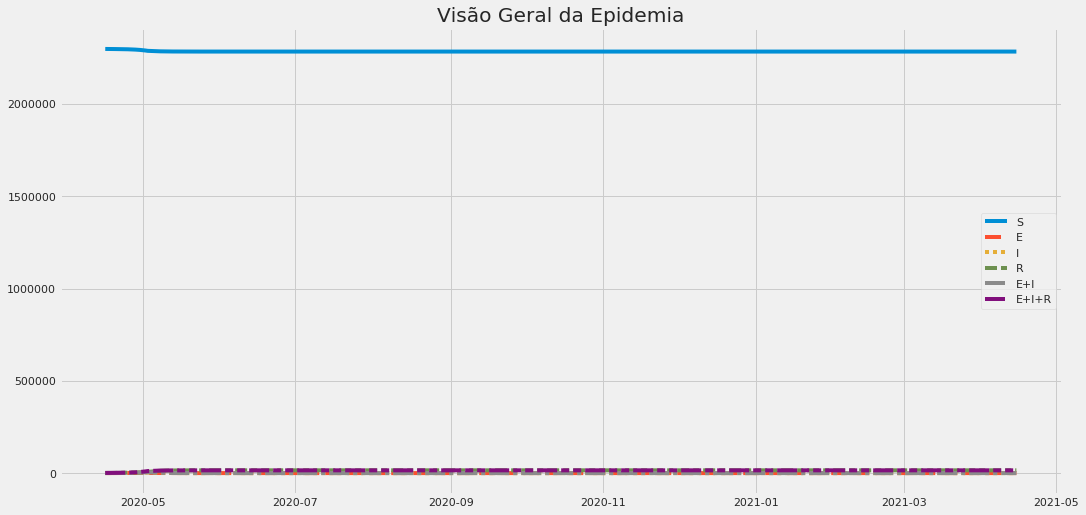

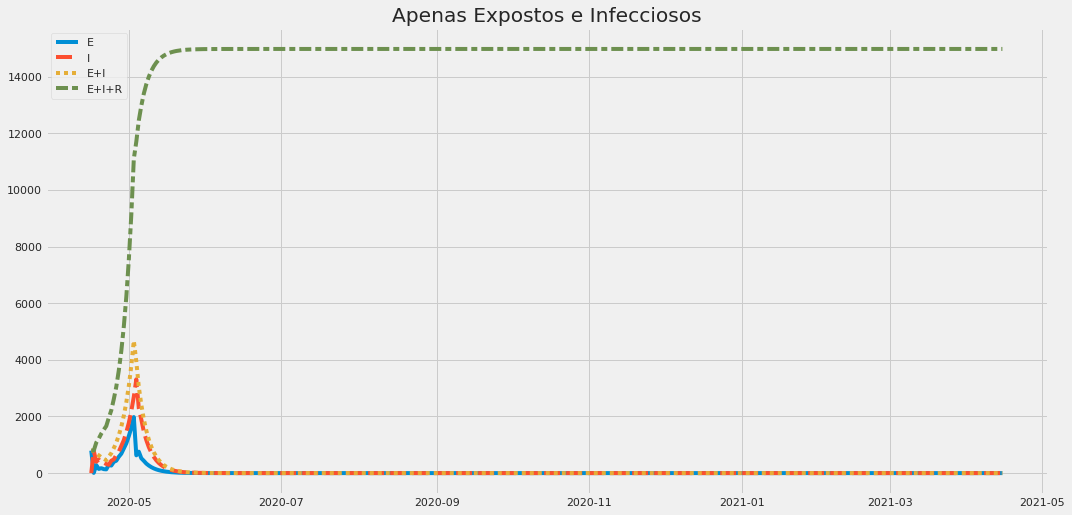

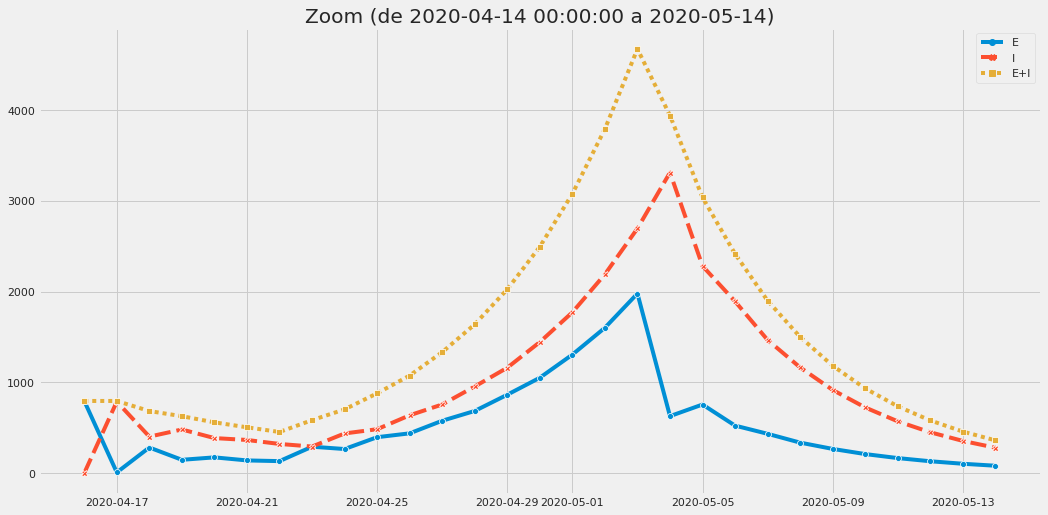

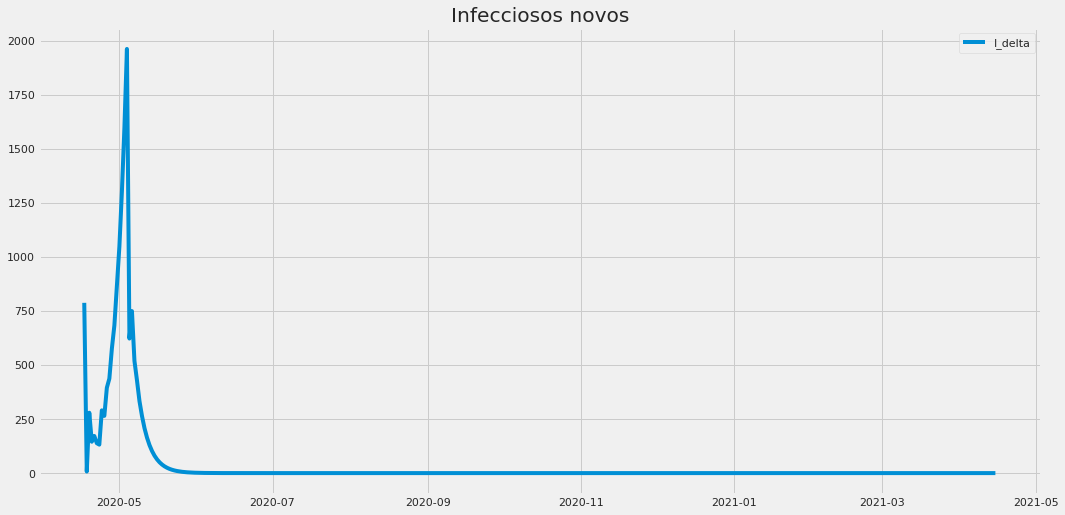

<Figure size 1152x576 with 0 Axes>

In [55]:
df_simulation_mitigation_data = simulate(S=population_size - initially_infected, 
                                          E=initially_infected,
                                          I=0,
                                          R=0, 
                                          alpha=alpha, beta=beta, gamma=gamma, 
                                          epidemic_start_date=epidemic_start_date, 
                                          epidemic_duration_in_days=epidemic_duration_in_days, 
                                          s_func=s, 
                                          e_func=e,
                                          i_func=i, 
                                          r_func=r,
                                          e_delta_func=e_delta,
                                          i_delta_func=i_delta,
                                          r_delta_func=r_delta)

plot_simulation_output(df_simulation_mitigation_data, zoom_length=30, file_name='dynamic')

In [56]:
best['beta_3'] / best['gamma_1']

0.4563177577206018

Como isso essa versão com mitigação se compara visualmente com os dados reais observados?

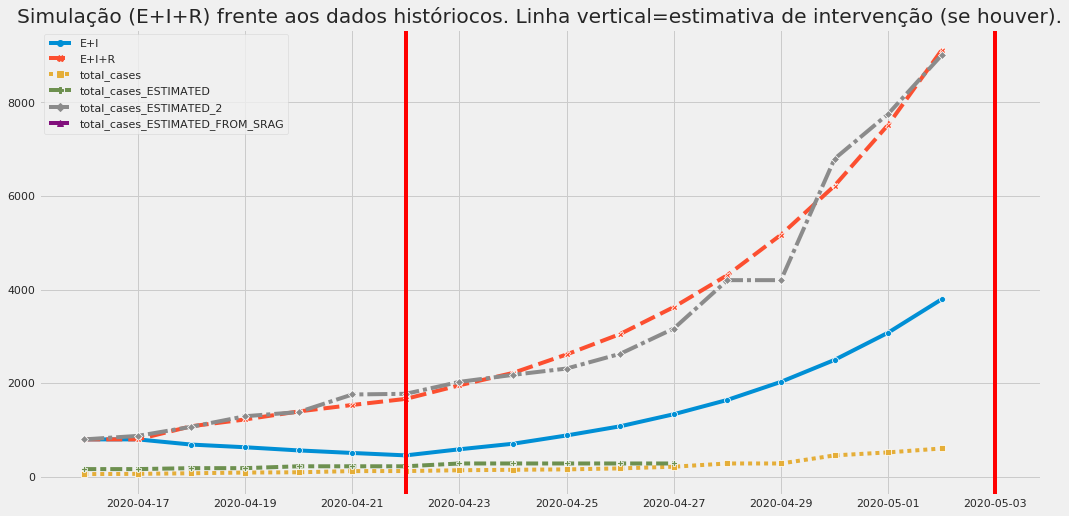

In [57]:
plot_curve_fitting(df_simulation_data=df_simulation_mitigation_data, 
                   df_data_target=df_data_target, 
                   target_location=target_location, 
                   best=best, 
                   file_name='seir_dynamic_fit_zoom')

Finalmente, comparemos os casos com e sem mitigação.

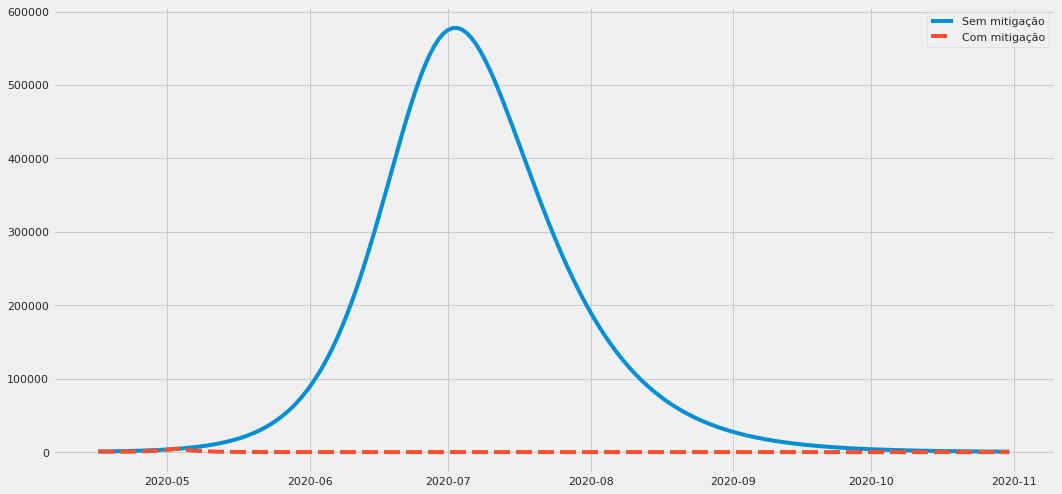

In [58]:
ax = sns.lineplot(data=pd.concat([df_simulation_data['E+I'].rename('Sem mitigação'), 
                                 df_simulation_mitigation_data['E+I'].rename('Com mitigação')], axis=1)['2020-03':'2020-10'])

ax.figure.savefig(results_folder + 'seir_constant_vs_dynamic' + f'_{target_location.lower()}' + results_suffix + '.png', 
                  format='png')

Salvemos os resultados.

In [59]:
df_simulation_mitigation_data.to_csv(results_folder + f'seir_dynamic_model_output.{target_location.lower()}.csv')

## Estudo de Calibragem de Parâmetros Variando-se Pontos de Corte Históricos 

Podemos também considerar o que ocorre com o treino do modelo conforme adquirimos mais dados históricos, simulando o ajuste do modelo ao longo de algumas janelas de tempo.

In [60]:
len(df_data_target)

19

In [61]:
%%time
if run_sensitivity_analysis:
    ss = []
    r0s = []
    for t in range(7, len(df_data_target), 1):
        print(f'###### t={t} ######')
        #space = {'constant':(hyperopt.hp.uniform('alpha', 0.99, 1.0), hyperopt.hp.uniform('beta', 0.0, 1.0), hyperopt.hp.uniform('gamma', 0.0, 1.0), 0, t)}

        t_2 = 10 if t >= 15.0 else 0.1
        t_3 = 10 if t >= 20.0 else 0.1

        ## assuming different gammas
        #
        #space = \
        #    {'dynamic':\
        #        ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
        #           {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_2', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
        #         {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0), 
        #           'gamma': hyperopt.hp.uniform('gamma_3', 0.0, 1.0),
        #           'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
        #        0, t)
        #    }

        # assuming gamma_1 == gamma_2 == gamma_3
        space = \
            {'dynamic':\
                ([{'alpha': hyperopt.hp.uniform('alpha_1', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_1', 0.2, 1.0), 
                   'gamma': hyperopt.hp.uniform('gamma_1', 0.0, 1.0),
                   'duration': hyperopt.hp.uniform('duration_1', 0.0, t)}, 
                   {'alpha': hyperopt.hp.uniform('alpha_2', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_2', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_2', 0.0, t_2)},
                 {'alpha': hyperopt.hp.uniform('alpha_3', 0.99, 1.0), 'beta': hyperopt.hp.uniform('beta_3', 0.2, 1.0),
                   'duration': hyperopt.hp.uniform('duration_3', 0.0, t_3)}], 
                0, t)
            }

        trials = hyperopt.Trials()
        best = hyperopt.fmin(objective_for_simulation, space, algo=hyperopt.tpe.suggest, max_evals=3000, trials=trials)

        print("Best parameters found:", best)

        alpha = dynamic_parameter([(best['alpha_1'], best['duration_1']), 
                                    (best['alpha_2'], best['duration_2']),
                                    (best['alpha_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
        beta = dynamic_parameter([(best['beta_1'], best['duration_1']), 
                                    (best['beta_2'], best['duration_2']),
                                    (best['beta_3'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)
       #gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
       #                            (best['gamma_2'], best['duration_2']),
       #                            (best['gamma_3'], best['duration_3'])],
       #                            min_length=epidemic_duration_in_days)
        gamma = dynamic_parameter([(best['gamma_1'], best['duration_1']), 
                                    (best['gamma_1'], best['duration_2']),
                                    (best['gamma_1'], best['duration_3'])],
                                    min_length=epidemic_duration_in_days)

        r0_1 = best['beta_1'] / best['gamma_1']
        r0_2 = best['beta_2'] / best['gamma_1'] # / best['gamma_2']
        r0_3 = best['beta_3'] / best['gamma_1'] # / best['gamma_3']

        r0s.append((r0_1, r0_2, r0_3))
        print(f'R0_1={r0_1}, R0_2={r0_2}, R0_3={r0_3}')


        df_simulation_partial_data = simulate(S=population_size - initially_infected, 
                                                  E=initially_infected,
                                                  I=0,
                                                  R=0, 
                                                  alpha=alpha, beta=beta, gamma=gamma, 
                                                  epidemic_start_date=epidemic_start_date, 
                                                  epidemic_duration_in_days=epidemic_duration_in_days, 
                                                  s_func=s, 
                                                  e_func=e,
                                                  i_func=i, 
                                                  r_func=r,
                                                  e_delta_func=e_delta,
                                                  i_delta_func=i_delta,
                                                  r_delta_func=r_delta)

        ss.append(df_simulation_partial_data['E+I'].rename(f'E+I, t <= {t}'))
        #ax = sns.lineplot(data=df_simulation_partial_data['E+I']['2020-03':'2020-07'])

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.25 µs


In [62]:
if run_sensitivity_analysis:
    df_r0 = pd.DataFrame(r0s)
    df_r0 = df_r0[df_r0 < 25]#.rolling(3).mean()
    ax = sns.lineplot(data=df_r0, dashes=False)

In [63]:
if run_sensitivity_analysis:
    df = pd.concat(ss, axis=1)['2020-03':'2020-09']

In [64]:
if run_sensitivity_analysis:
    df_filtered = df.iloc[:, 25:]
    palette = sns.color_palette("coolwarm", len(df_filtered.columns))
    ax = sns.lineplot(data=df_filtered, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [65]:
if run_sensitivity_analysis:
    palette = sns.color_palette("coolwarm", len(df.columns))
    ax = sns.lineplot(data=df, dashes=False, palette=palette)
    ax.set_title('Comparação de diversos pontos de corte (t) nos dados históricos')

In [66]:
if run_sensitivity_analysis:
    ax.figure.savefig(results_folder + 'seir_multiple_historical_fits_2' + f'_{target_location.lower()}' + results_suffix + '.png', 
                      format='png')

    df.head()

Vemos que há grande sensibilidade do modelo frente a pequenos ajustes nos parâmetros de entrada, embora a maior quantidade de dados favoreça maior estabilidade.